In [1]:
from datetime import datetime # to retrieve the current time and data
import math # how to use math.pow(value, power)
import matplotlib.pyplot as plt # generate plots
import numpy as np
import os # to join strings into directory paths
import pandas as pd # dataframes
import random # generate random numbers
import statistics # to calculate the standard deviation
from scipy import stats # p value calculation - http://python-ds.com/python-p-value
from scipy.optimize import curve_fit


In [2]:
original_measurement_filename = 'original_measurements.txt'
well_description_file = "each_well_description.txt"


In [3]:
def is_number(a):
    """
    # will be True also for 'NaN'
    """

    try:
        number = float(a)
        return("yes")
    
    except ValueError:
        return("no")


In [4]:
def read_original_measurements():
    """
    
    """
    measurements = []
    readings = []
    
    with open(original_measurement_filename,'r') as ReadFile: 
        
        for row in ReadFile:
            
            row = row.split("\t")
             
            for item in row: 
                
                a = is_number(item)
                    
                if a == "yes":
                    measurements.append(float(item))
                    
                if ":" in str(item):
                    measurements.append(item)
                    
    return(measurements)


In [5]:
def list_all_well_names():
    """
    Read and sort all the wellnames from the metadata file
    """
    
    # Initialize list of all wellnames 
    list_of_well_names = []
    
    # Open the file describing each well used in the experiment
    with open(well_description_file,'r') as ReadFile:    
        for row in ReadFile:
            row = row.split(",")
            
            # If the row of the file begin with a number
            # Add the second item in the comma separated list to a running list
            a = is_number(row[0]) 
            if a == "yes":
                list_of_well_names.append(row[1])
                
    
    # Return the list of well names
    return(list_of_well_names)
                    

In [6]:
def build_dataframe():
    """
    
    """
    measurements = read_original_measurements()
    
    times = []
    readings = []
    for i in range(len(measurements)):
        
        if ":" in str(measurements[i]):
            
            time_clock = measurements[i]
            time_split = time_clock.split(":")
            
            if len(time_split) == 2:
                time_hour = float(time_split[0])*1/60 + float(time_split[1])*1/60*1/60 
            
            if len(time_split) == 3:
                time_hour = float(time_split[0]) + float(time_split[1])*1/60 + float(time_split[2])*1/60*1/60 
            
            times.append(time_hour)
            
            well_readings = [time_hour]
            
            # well_readings = measurements[i+1:i+98]
            
            for item in measurements[i+1:i+98]:
                well_readings.append(item)
            
            readings.append(well_readings)
        
    df = pd.DataFrame(readings)
    
    column_names = ['Time', 'Temperature']
    list_of_well_names = list_all_well_names()
    for well_name in list_of_well_names:
        column_names.append(well_name)
        
    df.columns = column_names

    return(df)

In [7]:
def plot_temperature(df):
    """
    Plot the temperature recorded during the experiment 
    """
    
    time = df.iloc[:, 0]
    temp = df.iloc[:, 1]
    
    plt.scatter(time, temp, color = [.5,.5,.5], label = 'Measurements')
    
    temp_average = sum(temp) / len(temp)
    temp_min = min(temp)
    temp_max = max(temp)
    
    x = np.linspace(min(time), max(time), 50)
    
    y = np.linspace(temp_max, temp_max, 50)
    plt.plot(x, y, color = [1,0,.5], linestyle= '--', label = str('Maximum = ' + str(round(temp_max,2))))
    
    y = np.linspace(temp_average, temp_average, 50)
    plt.plot(x, y, color = [1,0,0], linestyle= '--', label = str('Average = ' + str(round(temp_average,2))))
    
    y = np.linspace(temp_min, temp_min, 50)
    plt.plot(x, y, color = [1,.5,0], linestyle= '--', label = str('Minimum = ' + str(round(temp_min,2))))

    # Plot annotations
    plt.xlabel("Time (hours)")
    plt.ylabel("Temperature (deg C)")
    plt.title("The Microplate Reader Temperature Log")
    plt.legend(bbox_to_anchor=(1.05, .6))
    
    # Save figure 
    save_figure_name = os.path.join( "Figures", 'Summary', 'Temperature vs Time' + '.jpg')
    plt.savefig(save_figure_name, bbox_inches='tight')
    
    # Show figure
    plt.show()
    

In [8]:
def retrieve_well_description(well_number):
    """
    From the well number, 
    refer to a refereence file also saved in the program folder,
    return the well name, spore count, and alanine molarity
    """
    
     
    well_name, spore_count, alanine_mM  = 0, 0, 0
    
    with open(well_description_file,'r') as ReadFile: 
        
        for row in ReadFile:
            row = row.split(",")
            
            a = is_number(row[0]) 
            
            if a == "yes":
                if int(row[0]) == int(well_number):
                    
                    well_name = row[1]
                    spore_count = row[2]
                    alanine_mM = row[3]    
    
    return well_name, spore_count, alanine_mM 
    

In [9]:
def assign_color_experiment_parameters(well_num):
    """
    
    """
    color_set = [1,1,1]
    
    well_name, spore_count, alanine_mM = retrieve_well_description(well_num)
    
    # Adjust color for spore count variable
    if float(spore_count) == 100: 
        color_set[1] = 0.05
        
    elif float(spore_count) == 10: 
        color_set[1] = 0.3
    
    elif float(spore_count) == 1: 
        color_set[1] = 0.6
        
    elif float(spore_count) == .1: 
        color_set[1] = 0.95
        
    # Adjust color for alanine variable
    if float(alanine_mM) == 1: 
        color_set[0] = 0.95
        color_set[2] = 0.05

    else: 
        color_set[0] = 0.05
        color_set[2] = 0.95
            
    return(color_set)
    

In [10]:
def plot_each_well(df, times):
    """
    
    """
    
    for i in range(len(df.iloc[0, :])):
        
        # Number the well and collect the measurements
        well_num = i + 1
        all_measurements_from_one_well = df.iloc[:, i]
        
        # Describe the well 
        well_name, spore_count, alanine_mM = retrieve_well_description(well_num)
        description = ('Well ' + str(well_name) + ' (' +  str(spore_count) + '  mln Spores + '+ str(alanine_mM) + ' mM Alanine)')
     
        # Initiate a new figure  
        fig_rows, fig_columns, subplot_number = 3, 2, 0
        fig = plt.figure(figsize=(fig_columns*8, fig_rows*6))
         
        while subplot_number < 6: 
        
            subplot_number += 1
            plt.subplot(fig_rows, fig_columns, subplot_number)
            color_set = assign_color_experiment_parameters(well_num) 
        
            if subplot_number >= 5:
                plot_whole_group(well_num, df, times, 'opposite')
      
            if subplot_number >= 3:
                plot_whole_group(well_num, df, times, 'same')
                
            plt.scatter(times, all_measurements_from_one_well,  c = color_set, s = 30, label = str(well_name))
                    
            plt.xlabel("Time Lapsed (hours)")
            plt.ylabel("Kinetic Absorbance 650 nm")
            plt.title("Measurements of " + description)
            plt.legend(bbox_to_anchor=(-.2, .6))
            
            subplot_number += 1
            plt.subplot(fig_rows, fig_columns, subplot_number)
            
            if subplot_number >= 6:
                plot_whole_group_regression(well_num, df, times, 'opposite')
           
            if subplot_number >= 4:
                plot_whole_group_regression(well_num, df, times, 'same')
            
            plot_linear_regression(times, all_measurements_from_one_well, well_num)
                
            save_figure_name = os.path.join( "Figures", "Each Well", well_name + '.jpg')
            plt.savefig(save_figure_name, bbox_inches='tight')
       
            plt.show()
        
    

In [11]:
def truncated_to_extrema(time, measurements):
    """
    Truncated the lists to minimum and maximum
    """
      
    # Find the index for minimum and maximum measurement
    for i in range(len(measurements)):
        if measurements[i] == min(measurements):
            measurement_min_index = i
        
        if measurements[i] == max(measurements):
            measurement_max_index = i
            
    if measurement_max_index - measurement_min_index < 2:
        measurement_min_index = 30
        measurement_max_index = 60
                   
    time_truncated, measurements_truncated = [], []
    
    # Build a list of the time and measurement between the minimum and maximum 
    for i in range(len(measurements)):    
        if i >= measurement_min_index:
            if i <= measurement_max_index:
                measurements_truncated.append(measurements[i])
                time_truncated.append(time[i])
                
    return time_truncated, measurements_truncated
    
    
            

In [12]:
def calculate_growth_coefficient(time, measurements):
    """
    
    """
    
    time_matched, growth_coefficient_list = [], []
    
    for i in range(len(measurements)):
        
        if i > 0:
            
            growth_coefficient = (1 / time[i]) * math.log(measurements[i] / min(measurements))
            
            growth_coefficient_list.append(growth_coefficient)
            time_matched.append(time[i])
    
    
    return time_matched, growth_coefficient_list
            

In [13]:
def calculate_average_stdev(list):
    """
    Average and standard deviation calculated for a list
    """
    
    if len(list) > 2: 
        avg = sum(list)/len(list)
        stdev = statistics.stdev(list)
    
    else:
        avg = "Invalid"
        stdev = "Invalid"
    
    summary  = str(round(avg, 4))
    summary += str('+/-')
    summary += str(round(stdev, 4))
    
    return avg, stdev, summary
           

In [14]:
def plot_experimental_variables():
    """
    From the text file describing each well's experimental variables
    Plot each variable group
    """
    
    well_num_list, well_name_list, spore_count_list, alanine_mM_list = [], [], [], []
    
    for well_num in range(96):
        well_name, spore_count, alanine_mM = retrieve_well_description(well_num)
        
        if well_num > 0: 
            well_num_list.append(well_num)
            well_name_list.append(well_num)
            spore_count_list.append(spore_count)
            alanine_mM_list.append(alanine_mM)
            
    # Initiate a new figure  
    fig_rows, fig_columns, subplot_number = 1, 3, 0
    fig = plt.figure(figsize=(fig_columns*6, fig_rows*6))
    
    subplot_number += 1
    plt.subplot(fig_rows, fig_columns, subplot_number)
    
    plt.scatter(well_num_list, spore_count_list)
    for well_num in well_num_list: 
        color_set = assign_color_experiment_parameters(well_num) 
        plt.scatter(well_num, spore_count_list[well_num_list.index(well_num)], color = color_set)      
    plt.xlabel("Well Number")
    plt.ylabel("Spore Count (millions)")
    plt.title("Spore Count Per Well")
   
    subplot_number += 1
    plt.subplot(fig_rows, fig_columns, subplot_number)
    
    plt.scatter(well_num_list, alanine_mM_list)
    for well_num in well_num_list: 
        color_set = assign_color_experiment_parameters(well_num) 
        plt.scatter(well_num, alanine_mM_list[well_num_list.index(well_num)], color = color_set)      
    plt.xlabel("Well Number")
    plt.ylabel("Alanine Concentration (mM)")
    plt.title("Alanine Concentration Per Well")

    subplot_number += 1
    plt.subplot(fig_rows, fig_columns, subplot_number)
    plt.scatter(spore_count_list, alanine_mM_list)
    for well_num in well_num_list: 
        color_set = assign_color_experiment_parameters(well_num) 
        plt.scatter(spore_count_list[well_num_list.index(well_num)], alanine_mM_list[well_num_list.index(well_num)], color = color_set)      
    plt.xlabel("Spore Count (millions)")
    plt.ylabel("Alanine Concentration (mM)")
    plt.title("Alanine Concentration vs Spore Count")
    
    save_figure_name = os.path.join( "Figures", 'Summary', 'Metadata' + '.jpg')
    plt.savefig(save_figure_name, bbox_inches='tight')

    plt.show()
            

In [15]:
def plot_measurements(well_num, df):
    """
    
    """
    time = df.iloc[:, 0]
    
    color_set = assign_color_experiment_parameters(well_num)
    well_name, spore_count, alanine_mM = retrieve_well_description(well_num)
    description = (str(well_name) + ' (' +  str(spore_count) + '  mln Spores + '+ str(alanine_mM) + ' mM Alanine)')
            
    measurements = df.iloc[:, well_num + 1]
    
    plt.scatter(time, measurements, c = [.8, .8, .8], label = str(well_name + ' All Measurements'))
    
    time_truncated, measurements_truncated = truncated_to_extrema(time, measurements)
    plt.scatter(time_truncated, measurements_truncated, c = color_set, label = str(well_name + ' Min to Max'))
    
    time_truncated, measurements_truncated = truncated_to_preset(time_truncated, measurements_truncated)
    plt.scatter(time_truncated, measurements_truncated, c = color_set, marker = 'x', s = 100, label = str(well_name + ' 15 - 20 hrs'))
    
    # Plot annotations and describe the well  
    plt.xlabel("Time Lapsed (hours)")
    plt.ylabel("Kinetic Absorbance 650 nm")
    plt.title("Measurements of " + description)
    plt.legend()
    # plt.legend(bbox_to_anchor=(-.2, .6))
    

In [16]:
def truncated_to_preset(time, measurements):
    """
    Truncated the lists to minimum and maximum
    """
    
    time_min_index = 0
    time_max_index = len(time) - 1
      
    # Find the index for minimum and maximum measurement
    for i in range(len(time)):
        if time[i] > 15 and time[i] < 16:
            time_min_index = i
        
        if time[i] > 20 and time[i] < 21:
            time_max_index = i
                   
    time_truncated, measurements_truncated = [], []
    
    # Build a list of the time and measurement between the minimum and maximum 
    for i in range(len(time)):    
        if i >= time_min_index:
            if i <= time_max_index:
                measurements_truncated.append(measurements[i])
                time_truncated.append(time[i])
                
    return time_truncated, measurements_truncated
    

In [17]:
def plot_best_fit_through_data(well_num, df):
    """
    
    """
    time = df.iloc[:, 0]
    measurements = df.iloc[:, well_num + 1]
    time_truncated, measurements_truncated = truncated_to_extrema(time, measurements)
    time_truncated_2, measurements_truncated_2 = truncated_to_preset(time_truncated, measurements_truncated)
    
    color_set = assign_color_experiment_parameters(well_num)
    well_name, spore_count, alanine_mM = retrieve_well_description(well_num)
    description = (str(well_name) + ' (' +  str(spore_count) + '  mln Spores + '+ str(alanine_mM) + ' mM Alanine)')
    
    time_matched, growth_coefficient = calculate_growth_coefficient(time, measurements)
    avg, stdev, summary = calculate_average_stdev(growth_coefficient)
    
    best_fit_measurements = []
    for item in time_truncated:
        predicted = min(measurements) * math.exp(item * avg)
        best_fit_measurements.append(predicted)
    
    plt.scatter(time, measurements, c = color_set, label = "All Measurements")
    plt.plot(time_truncated,  best_fit_measurements, linestyle = ':', label = str("Growth Coefficient" + str(round(avg, 4))))
    
    time_truncated_2, measurements_truncated_2 = truncated_to_preset(time_truncated, measurements_truncated)  
    time_matched_2, growth_coefficient_2 = calculate_growth_coefficient(time_truncated_2, measurements_truncated_2)
    avg_2, stdev_2, summary = calculate_average_stdev(growth_coefficient_2)
    
    best_fit_measurements_2 = []
    for item in time_matched_2:
        predicted = min(measurements) * math.exp(item * avg_2)
        best_fit_measurements_2.append(predicted)
  
    plt.plot(time_matched_2,  best_fit_measurements_2, linestyle = '-', label = str("Growth Coefficient" + str(round(avg_2, 4))))
   
    
    # Plot annotations and describe the well  
    plt.xlabel("Time Lapsed (hours)")
    plt.ylabel("Kinetic Absorbance 650 nm")
    plt.title("Measurements of " + description)
    plt.legend()
    
    

In [18]:
def plot_growth_coefficients(well_num, df):
    """
    
    """
    time = df.iloc[:, 0]
    measurements = df.iloc[:, well_num + 1]
    time_truncated, measurements_truncated = truncated_to_extrema(time, measurements)
    time_truncated_2, measurements_truncated_2 = truncated_to_preset(time_truncated, measurements_truncated)
    
    color_set = assign_color_experiment_parameters(well_num)
    well_name, spore_count, alanine_mM = retrieve_well_description(well_num)
    description = (str(well_name) + ' (' +  str(spore_count) + '  mln Spores + '+ str(alanine_mM) + ' mM Alanine)')

    # Plot the coefficient assumming exponential growth 
    time_matched, growth_coefficient = calculate_growth_coefficient(time, measurements)
    avg, stdev, summary = calculate_average_stdev(growth_coefficient)
    plt.scatter(time_matched, growth_coefficient, c = [.8, .8, .8], label = str(well_name + ' All Measurements ' + summary))
            
    time_matched, growth_coefficient = calculate_growth_coefficient(time_truncated, measurements_truncated)
    avg, stdev, summary = calculate_average_stdev(growth_coefficient)
    plt.scatter(time_matched, growth_coefficient, c = color_set, label = str(well_name + ' Min to Max ' + summary))
         
    time_matched, growth_coefficient = truncated_to_preset(time_matched, growth_coefficient)
    avg_2, stdev_2, summary = calculate_average_stdev(growth_coefficient)
    plt.scatter(time_matched, growth_coefficient, c = color_set, marker = 'x', s = 100, label = str(well_name + ' 15 - 20 hrs ' + summary))
     
    # Plot annotations and describe the well  
    plt.xlabel("Time Lapsed (hours)")
    plt.ylabel("Exponential Growth Coefficient (1/hr)")
    plt.title("Growth Coefficient of " + description)
    plt.legend()
    
    return(avg, stdev)
               

In [19]:
def plot_all_growth_coefficients(well_num, growth_coefficients):
    """
    
    """
    
    # Initiate a new figure  
    fig_rows, fig_columns, subplot_number =3, 2, 0
    fig = plt.figure(figsize=(fig_columns*8, fig_rows*6))
       
    # Scatter plot by well number
    subplot_number += 1
    plt.subplot(fig_rows, fig_columns, subplot_number)
          
    for i in range(len(well_num)):
        color_set = assign_color_experiment_parameters(well_num[i])
        plt.scatter(well_num[i], growth_coefficients[i], c = color_set)
    
    # Plot annotations and describe the well  
    plt.xlabel("Well Number")
    plt.ylabel("Exponential Growth Coefficient (1/hr)")
    plt.title("Growth Coefficient of All Wells")
    
    
    # Scatter plot of alanine concentration vs growth coefficient
    subplot_number += 1
    plt.subplot(fig_rows, fig_columns, subplot_number)
 
    for i in range(len(well_num)):
        well_name, spore_count, alanine_mM = retrieve_well_description(well_num[i])
        color_set = assign_color_experiment_parameters(well_num[i])
        plt.scatter(float(alanine_mM), growth_coefficients[i], c = color_set)
        
    # Plot annotations and describe the well  
    plt.xlabel("Alanine Concentration (mM)")
    plt.ylabel("Exponential Growth Coefficient (1/hr)")
    plt.title("Growth Coefficient vs Alanine Concentration")
    
    
     # Scatter plot of alanine concentration vs growth coefficient
    subplot_number += 1
    plt.subplot(fig_rows, fig_columns, subplot_number)
 
    for i in range(len(well_num)):
        well_name, spore_count, alanine_mM = retrieve_well_description(well_num[i])
        color_set = assign_color_experiment_parameters(well_num[i])
        
        x_var = math.log(float(spore_count), 10) + 1 + (float(alanine_mM) * .5)
        plt.scatter(x_var, growth_coefficients[i], c = color_set)
        
    # Plot annotations and describe the well  
    plt.xlabel("Spore Count (mln) | Alanine Concentration (mM)")
    plt.ylabel("Exponential Growth Coefficient (1/hr)")
    plt.title("Effect of Spore Count and Alanine Concentration")
    
    x_names = ['0.1|0', '0.1|1.0', '1|0', '1|1.0', '10|0', '10|1.0', '100|0', '100|1.0',]
    x_nums = np.linspace(0, len(x_names)/2 - 0.5, len(x_names))
    plt.xticks(x_nums, x_names)
    
     # Scatter plot of alanine concentration vs growth coefficient
    subplot_number += 1
    plt.subplot(fig_rows, fig_columns, subplot_number)
 
    for i in range(len(well_num)):
        well_name, spore_count, alanine_mM = retrieve_well_description(well_num[i])
        color_set = assign_color_experiment_parameters(well_num[i])
        
        x_var = math.log(float(spore_count), 10) + 2 + (float(alanine_mM) * 4)
        plt.scatter(x_var, growth_coefficients[i], c = color_set)
        
    # Plot annotations and describe the well  
    plt.xlabel("Spore Count (mln) | Alanine Concentration (mM)")
    plt.ylabel("Exponential Growth Coefficient (1/hr)")
    plt.title("Effect of Spore Count and Alanine Concentration")
    
    x_names = ['0.1|0', '1|0', '10|0', '100|0', '0.1|1.0', '1|1.0', '10|1.0', '100|1.0',]
    x_nums = np.linspace(1, len(x_names), len(x_names))
    plt.xticks(x_nums, x_names)
    
    
    # Scatter plot of alanine concentration vs growth coefficient
    subplot_number += 1
    plt.subplot(fig_rows, fig_columns, subplot_number)
 
    for i in range(len(well_num)):
        well_name, spore_count, alanine_mM = retrieve_well_description(well_num[i])
        color_set = assign_color_experiment_parameters(well_num[i])
        
        x_var = math.log(float(spore_count),10)
        
        if float(alanine_mM) > 0: 
            color_set = assign_color_experiment_parameters(7)
        else: 
            color_set = assign_color_experiment_parameters(1)
            
        plt.scatter(x_var, growth_coefficients[i])
        
    # Plot annotations and describe the well  
    plt.xlabel("Spore Count (mln)")
    plt.ylabel("Exponential Growth Coefficient (1/hr)")
    plt.title("Effect of Spore Count and Alanine Concentration")
    
     # Save figure 
    save_figure_name = os.path.join( "Figures", "Summary", "All Growth Coefficients" + '.jpg')
    plt.savefig(save_figure_name, bbox_inches='tight')
  
    plt.show()
    

In [20]:
def plot_each_well(df):
    """
    From the dataframe - time, temperature, measurements of each well
    Plot the measurements
    """
    
    well_num_list, growth_coefficients_list = [], []
    
    for i in range(len(df.iloc[0, :])):
        
        # Initiate a new figure  
        fig_rows, fig_columns, subplot_number = 1, 3, 0
        fig = plt.figure(figsize=(fig_columns*8, fig_rows*8))
           
        if i >= 2: 
            
            # Plot measurements
            subplot_number += 1
            plt.subplot(fig_rows, fig_columns, subplot_number)
            plot_measurements(i-1, df)
            
            # Plot growth coefficients
            subplot_number += 1
            plt.subplot(fig_rows, fig_columns, subplot_number)
            avg, stdev = plot_growth_coefficients(i-1, df)
            
            # Plot growth coefficients
            subplot_number += 1
            plt.subplot(fig_rows, fig_columns, subplot_number)
            plot_best_fit_through_data(i-1, df)
           
            
            print(avg)
            
            if avg != "Invalid": 
                well_num_list.append(i-1)
                growth_coefficients_list.append(avg) 
            
            # Save figure 
            well_name, spore_count, alanine_mM = retrieve_well_description(i-1)
            save_figure_name = os.path.join( "Figures", "Each Well", well_name + '.jpg')
            plt.savefig(save_figure_name, bbox_inches='tight')

            plt.show()
            
    plot_all_growth_coefficients(well_num_list, growth_coefficients_list)
        
        


In [ ]:
def main():
    """
    
    """
    
    # Test 
    print('Program executing')
    
    # Plot the experimental variables with color assigned to each group   
    plot_experimental_variables()
    
    # Build the dataframe 
    df = build_dataframe()
    
    # Plot the temperature during the experiment
    plot_temperature(df)
       
    # Build 
    plot_each_well(df)

    

Program executing


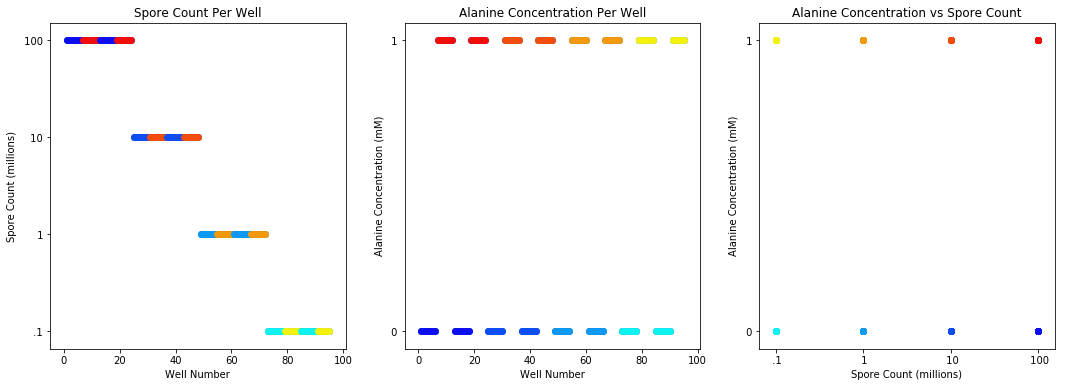

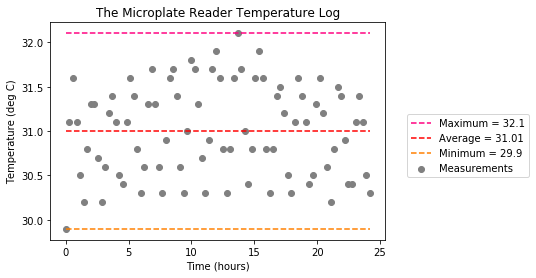

0.00944835637966


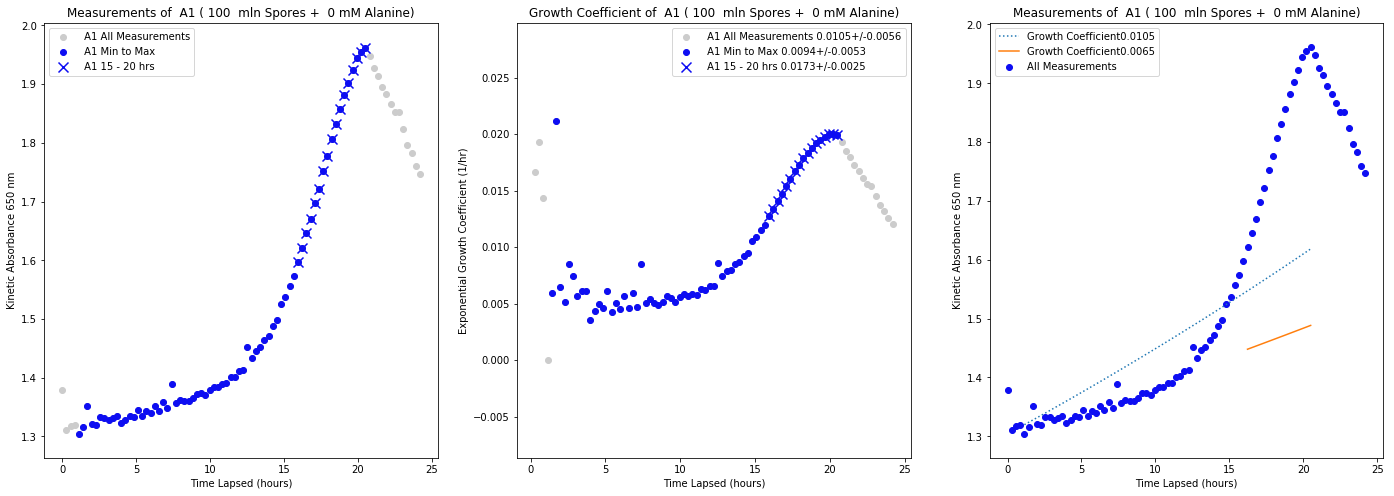

0.0158022588607


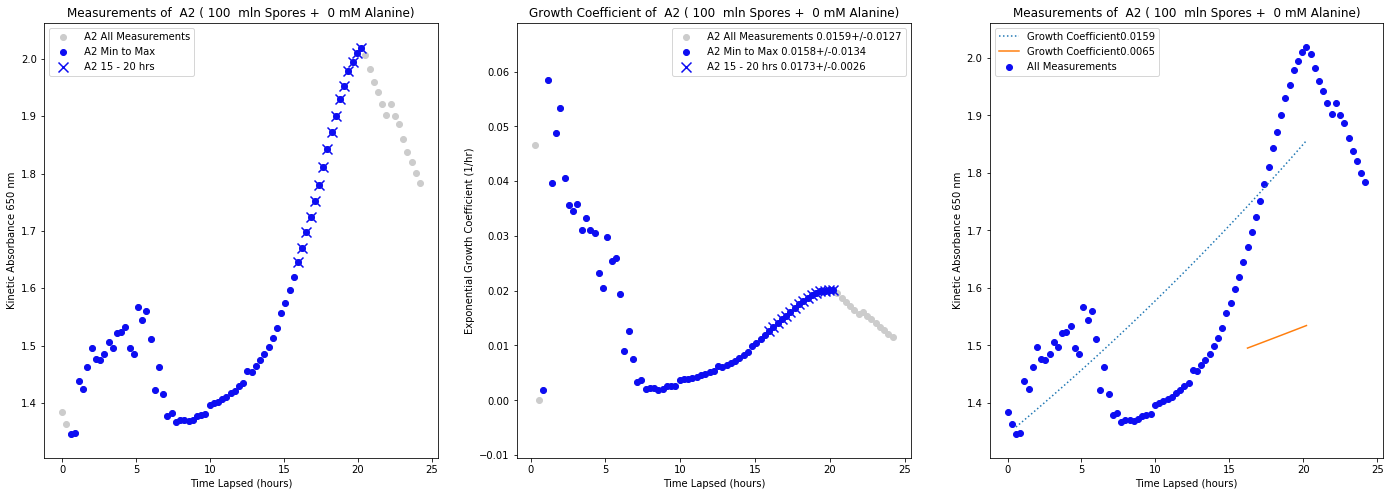

0.00808568702839


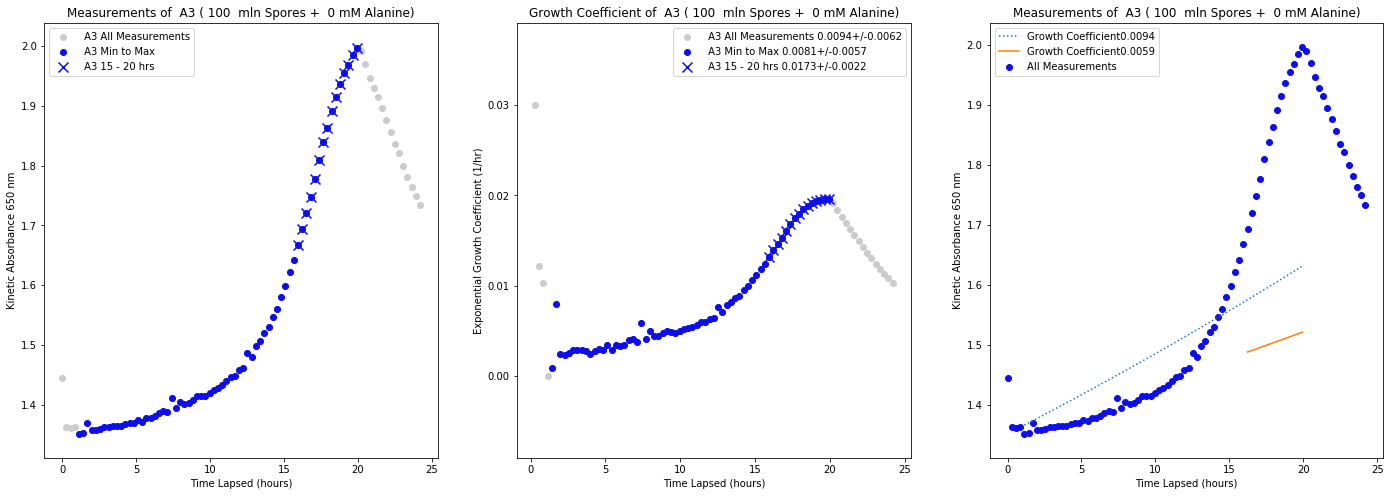

0.00673397998607


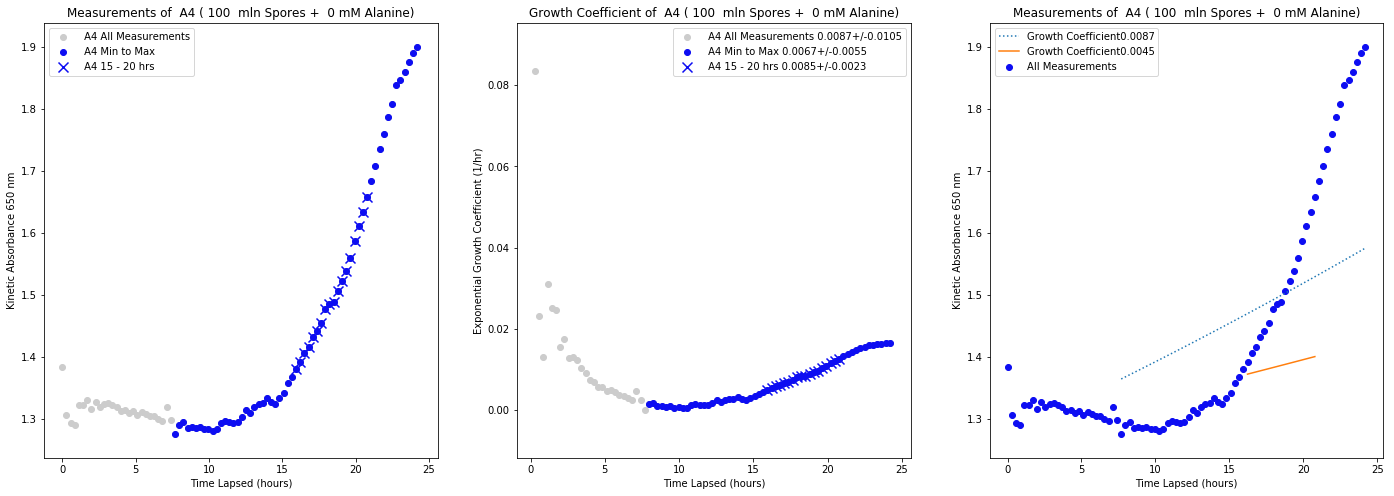

0.012293511697


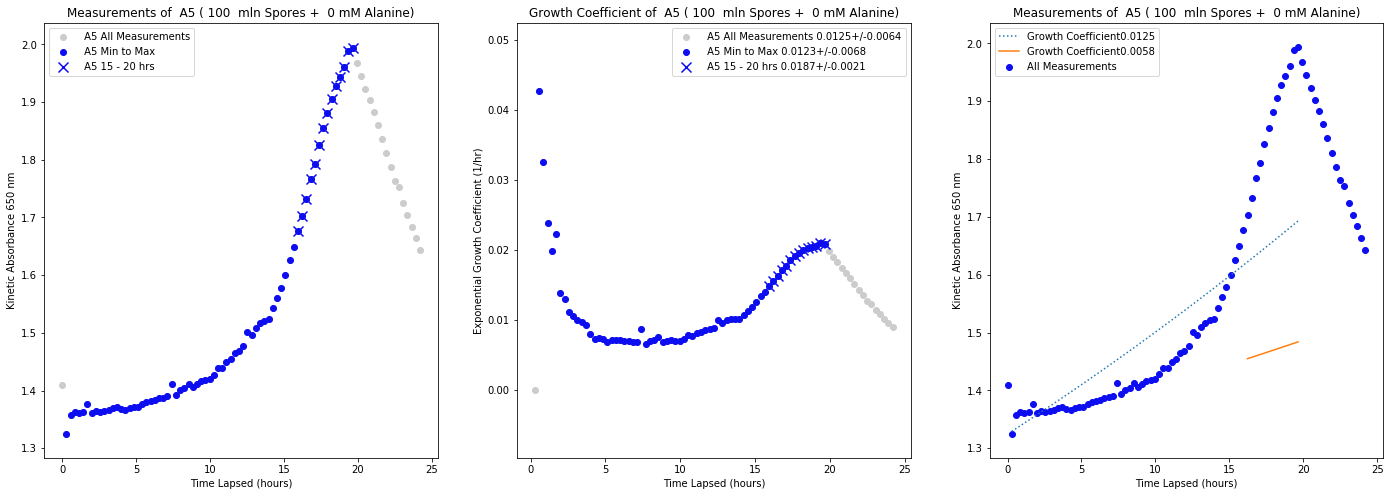

0.0102167115037


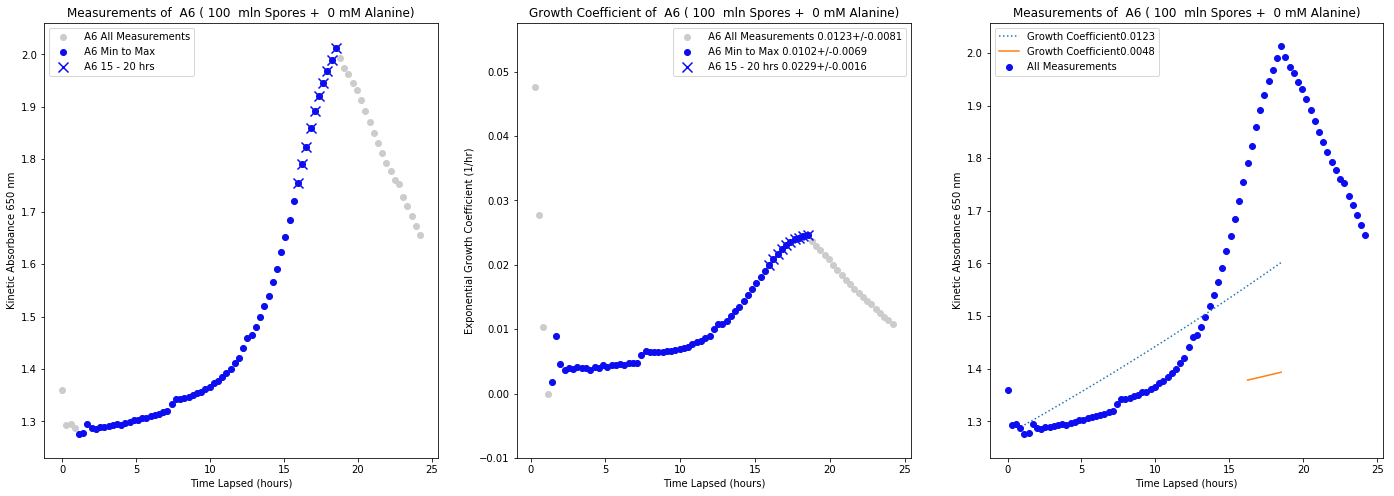

0.00434649568876


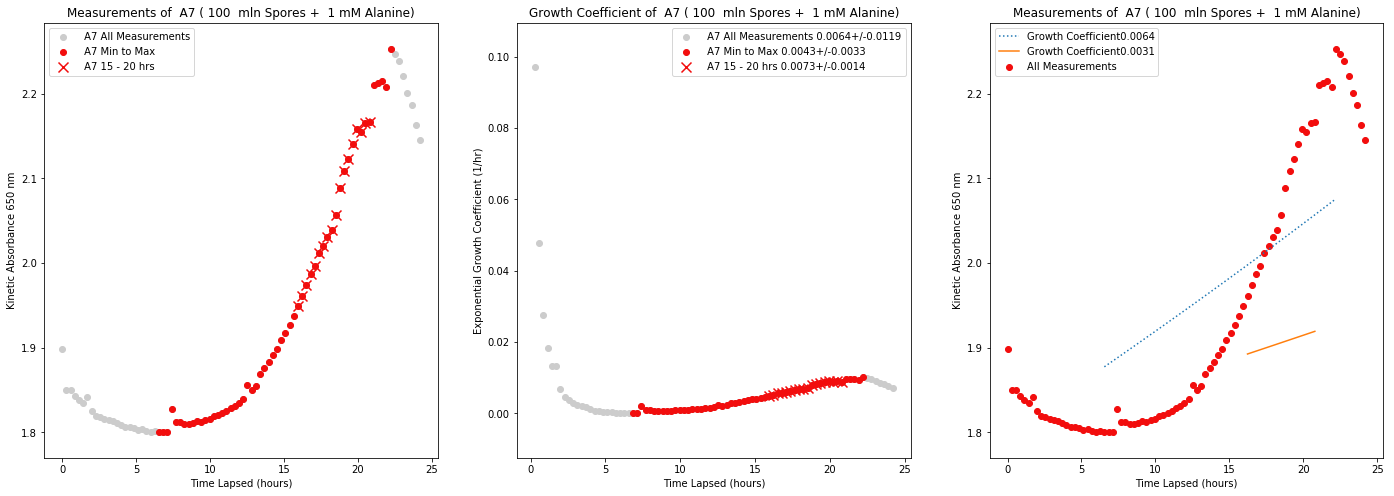

0.0045921672595


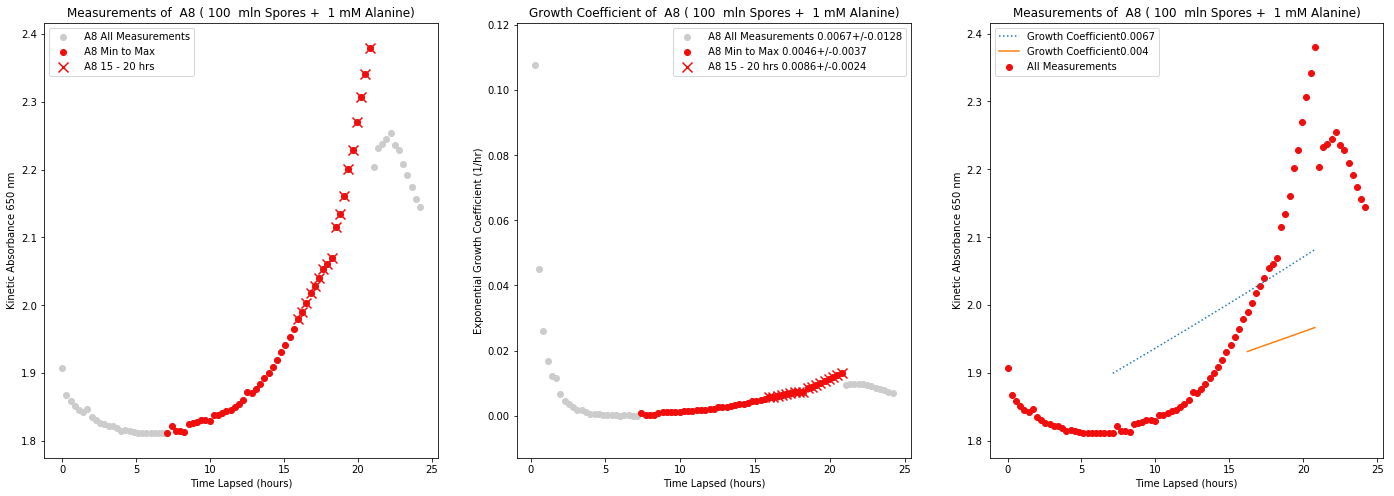

0.00403876704491


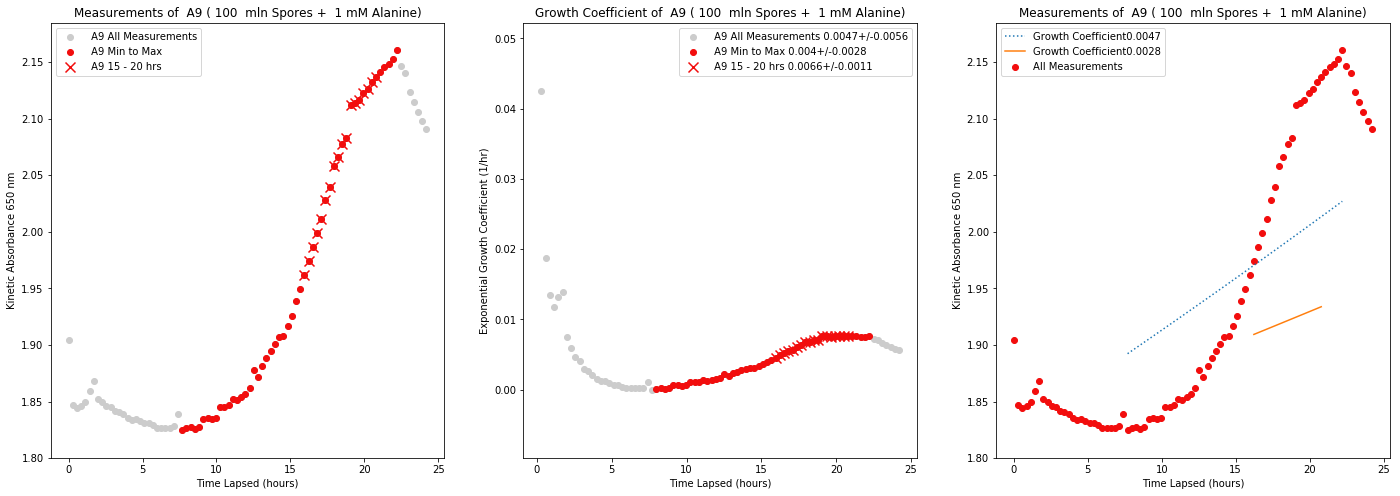

0.00491257207582


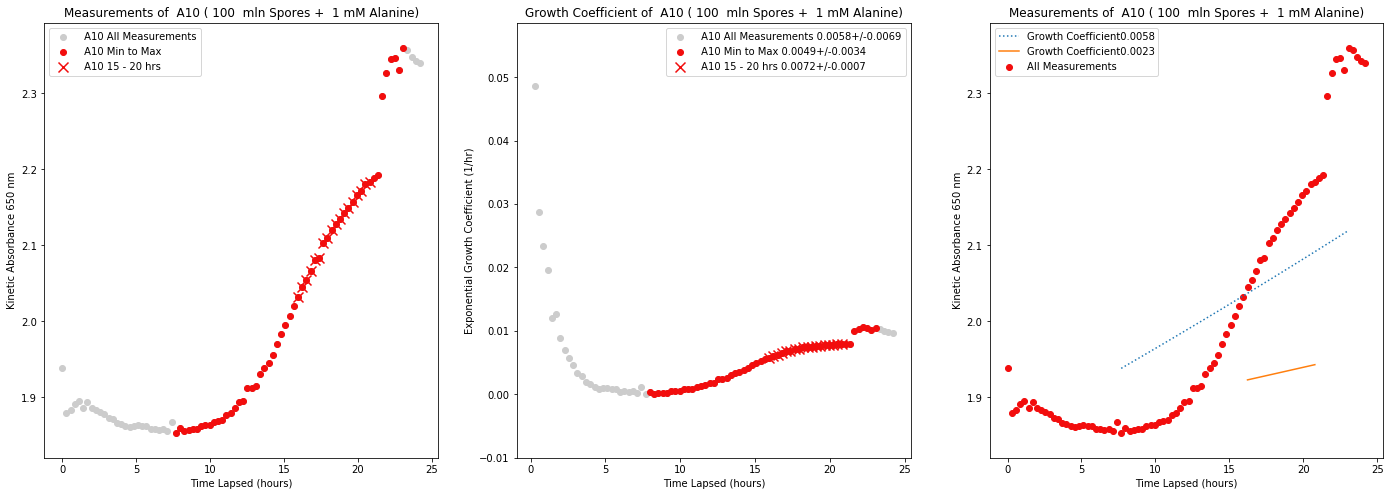

0.00434602608534


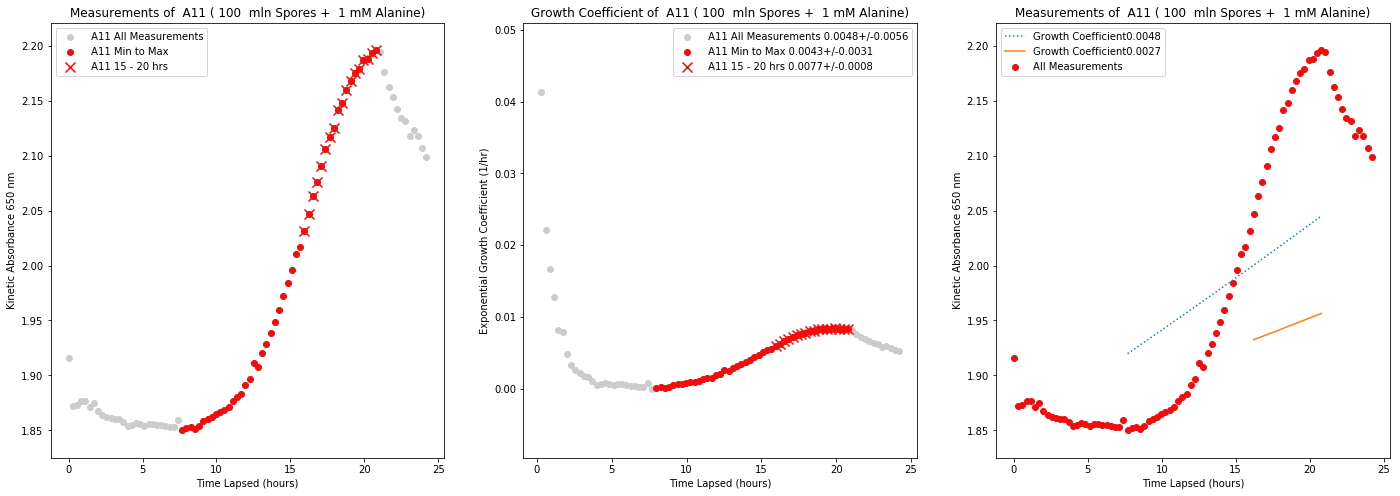

0.00491250534465


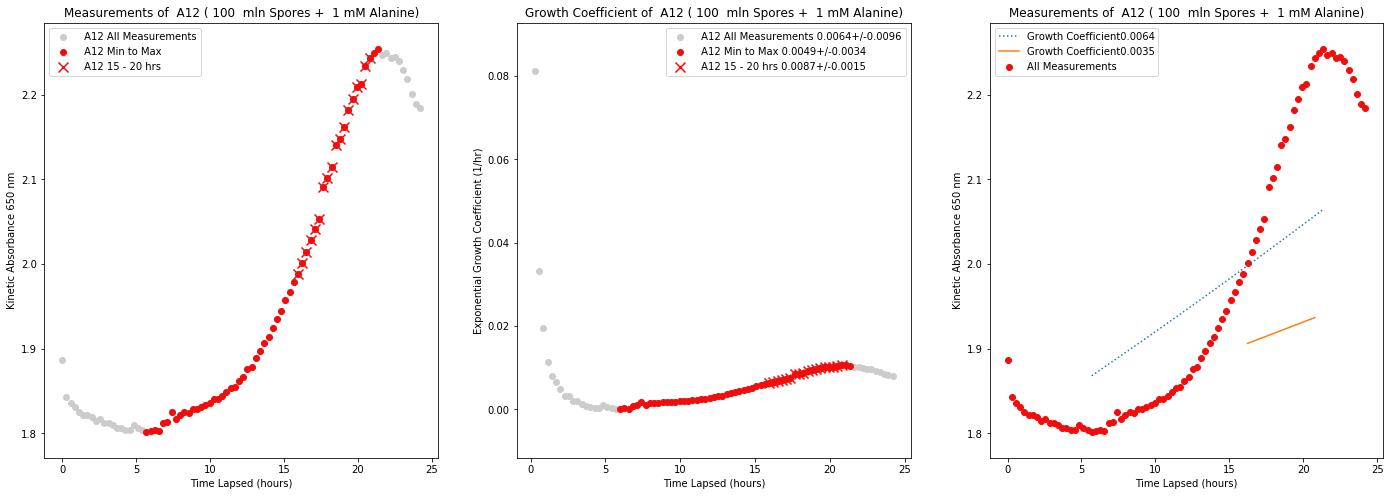

0.0106223258831


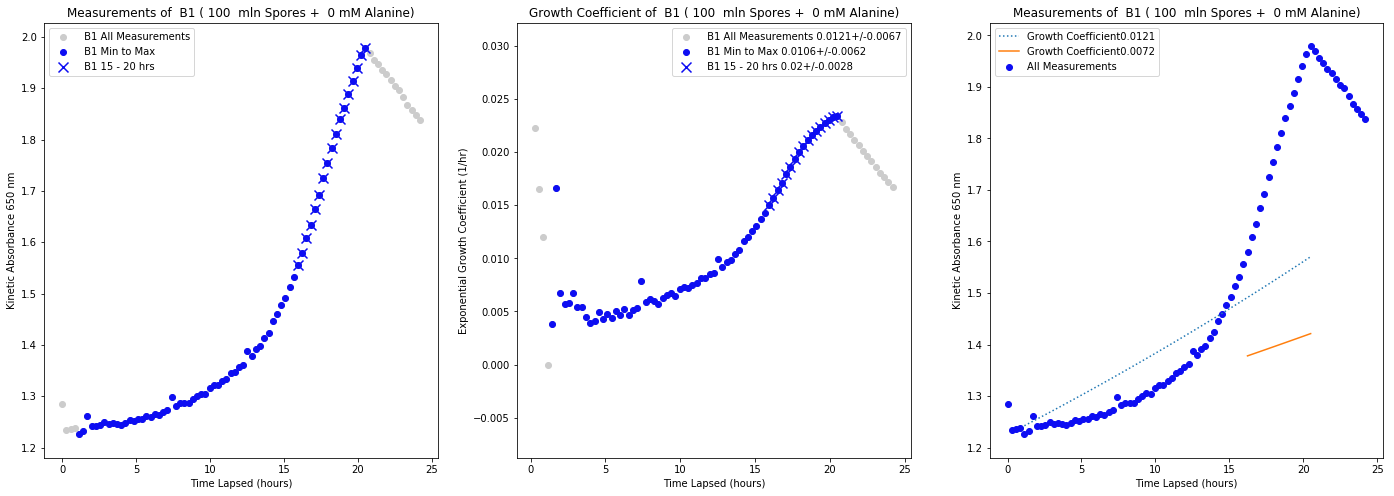

0.0106635862264


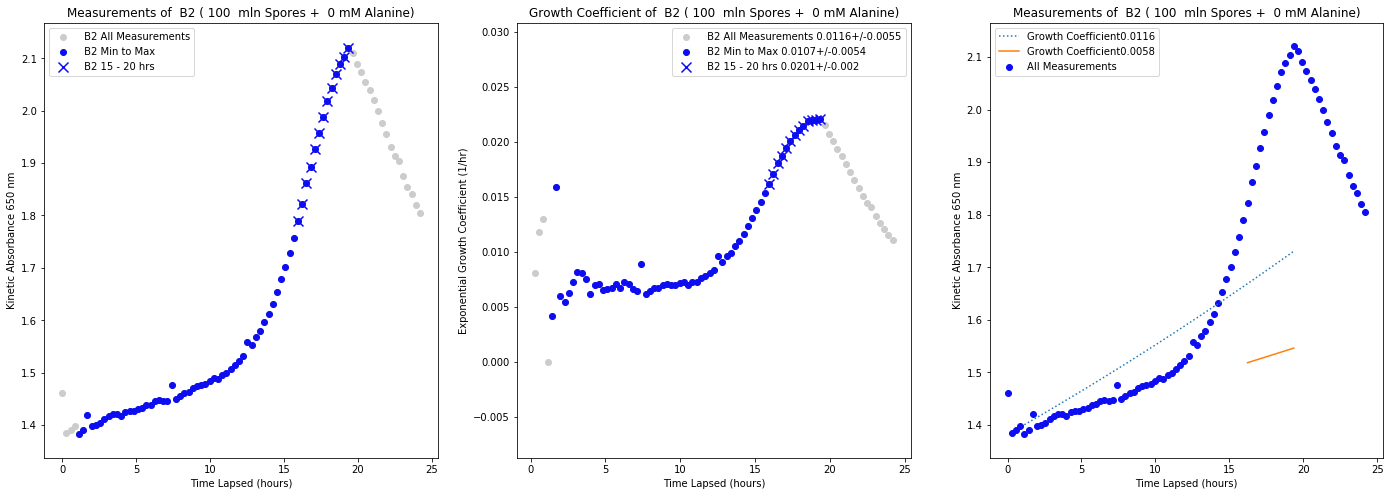

0.0102283217299


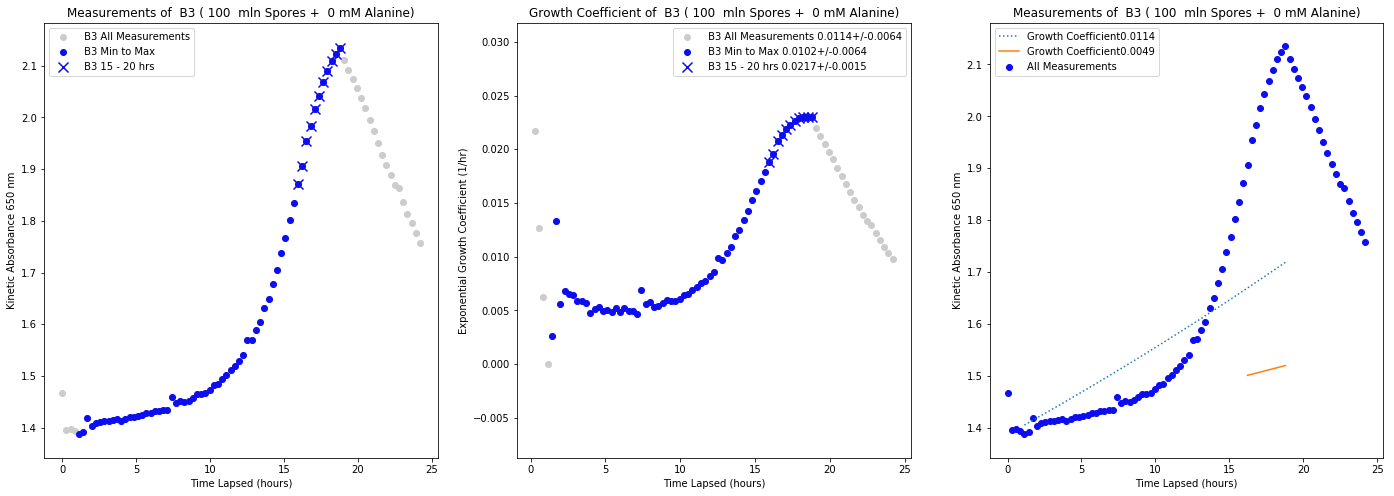

0.0119963338218


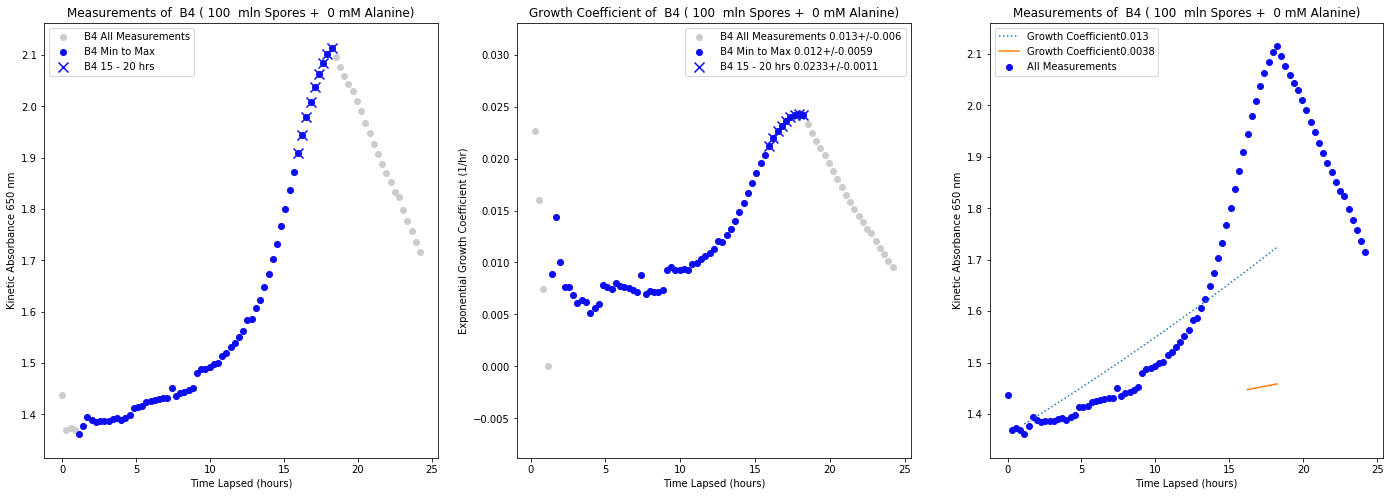

0.0233576586328


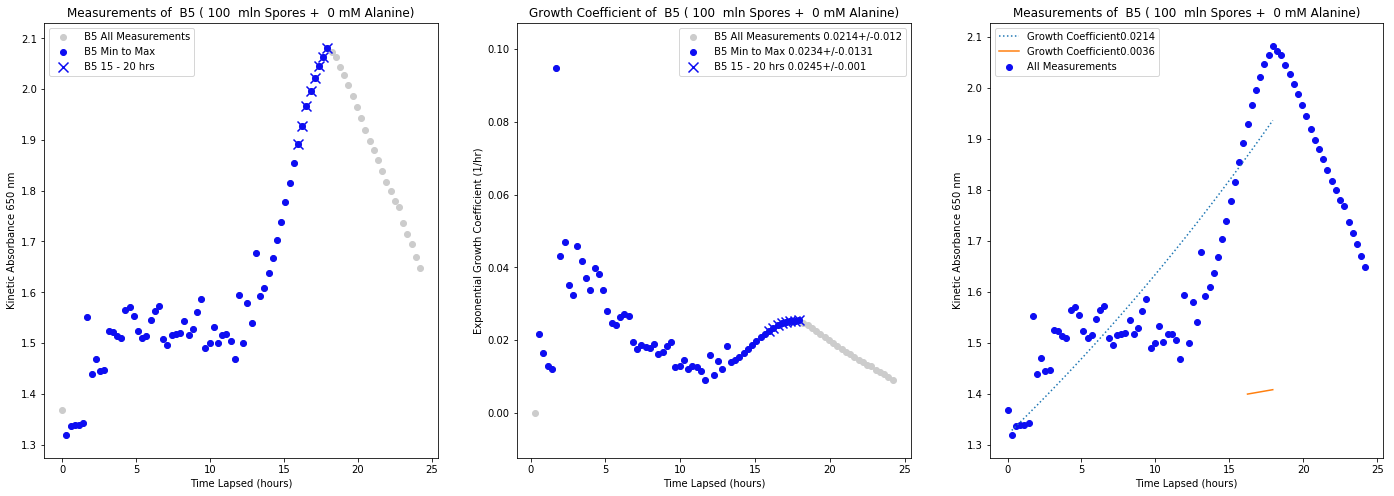

0.0180208335172


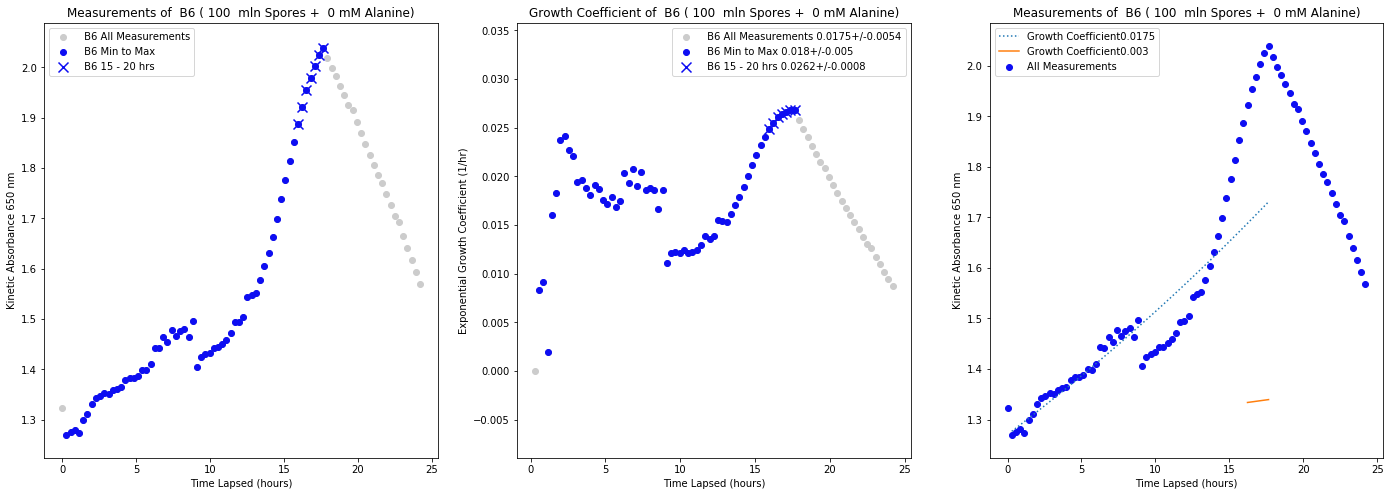

0.00362412466495


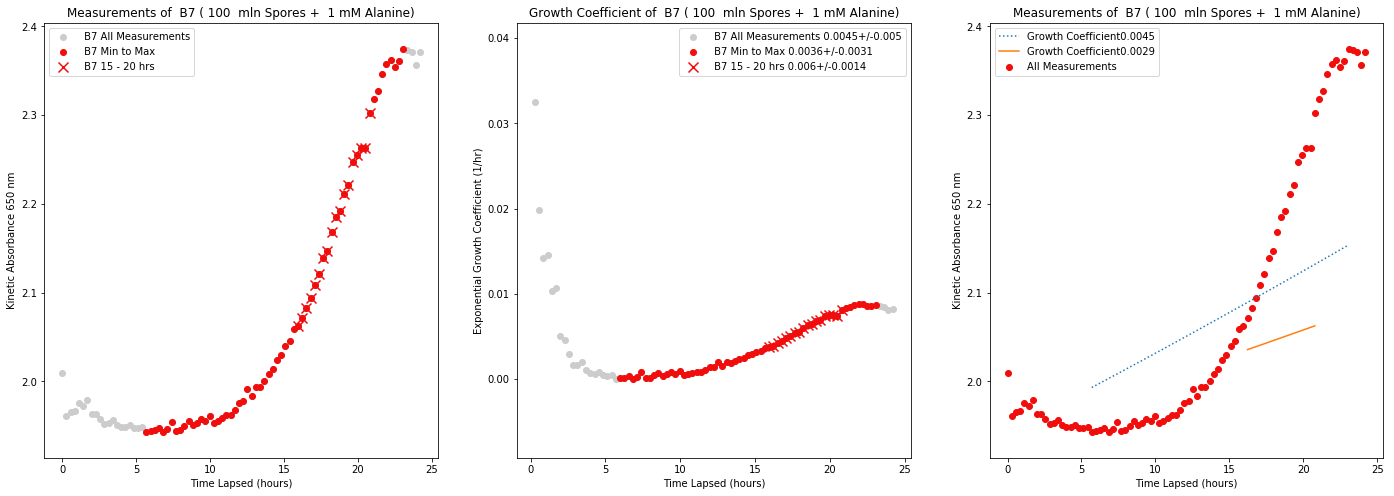

0.00358119943747


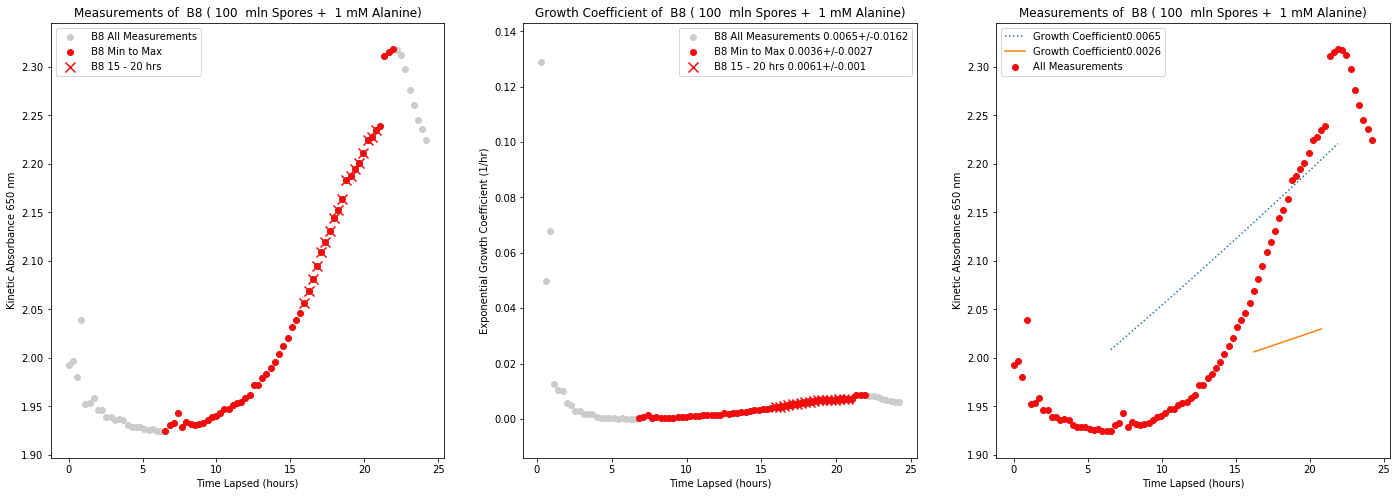

0.00411484678484


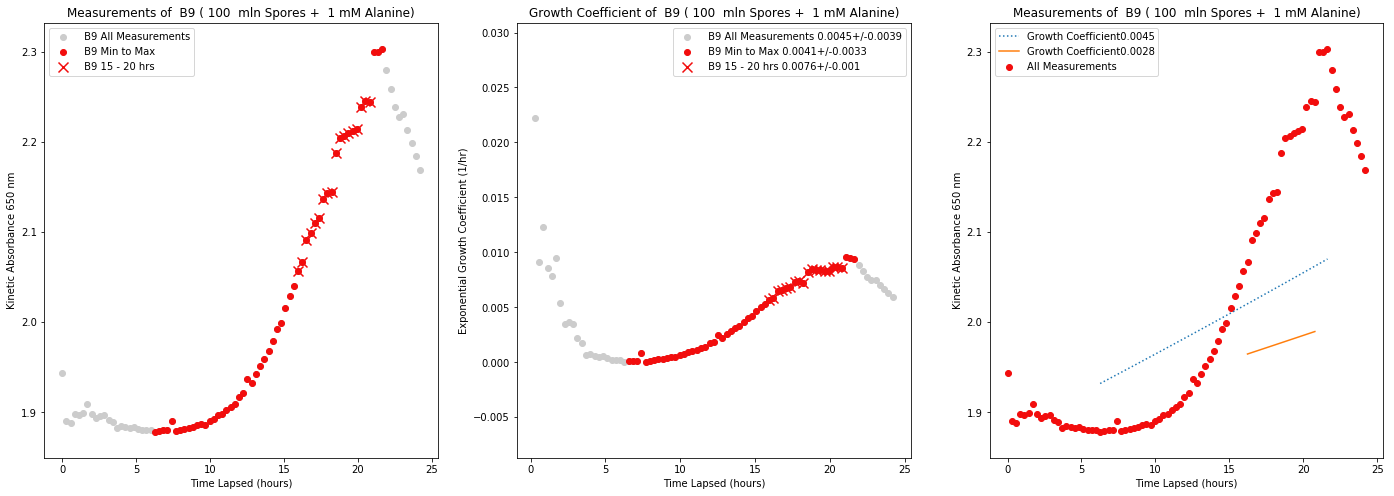

0.00430374377412


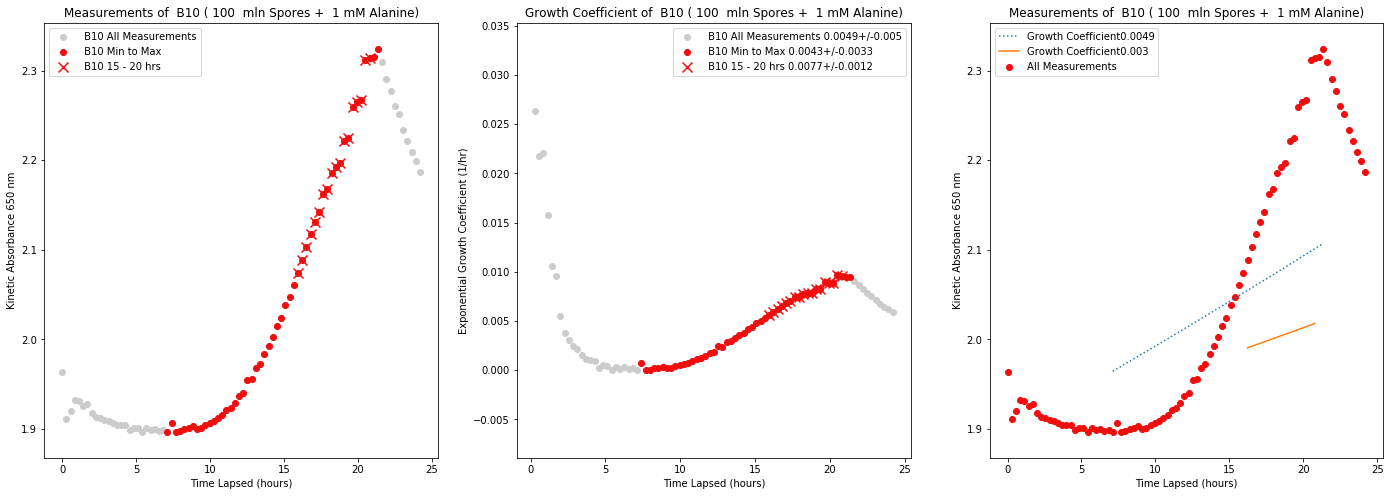

0.00434909684007


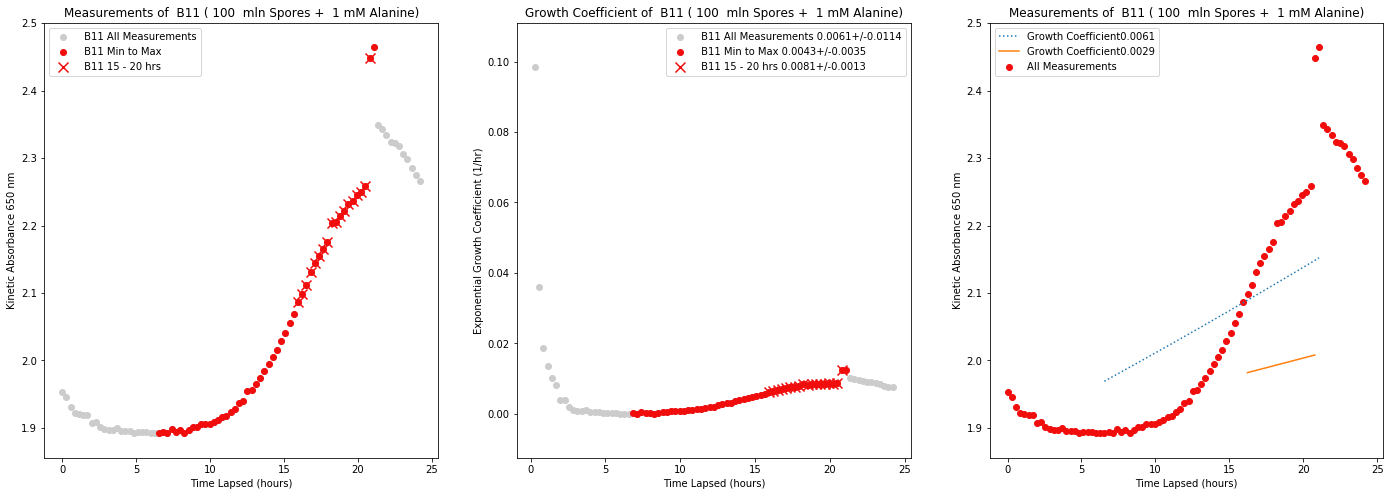

0.00452106152308


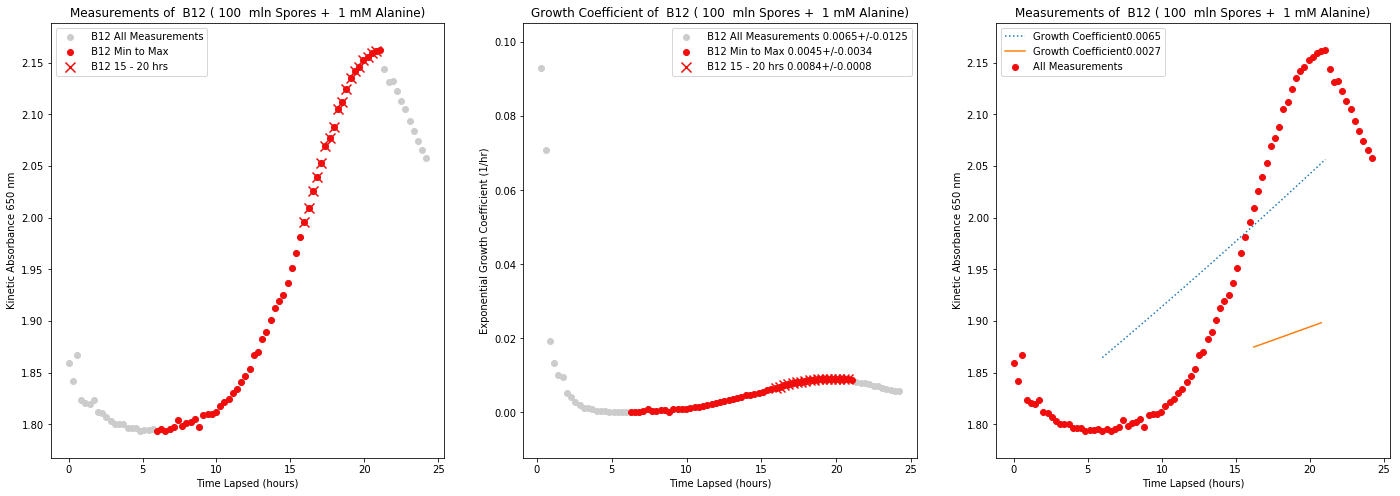

0.0512893220276


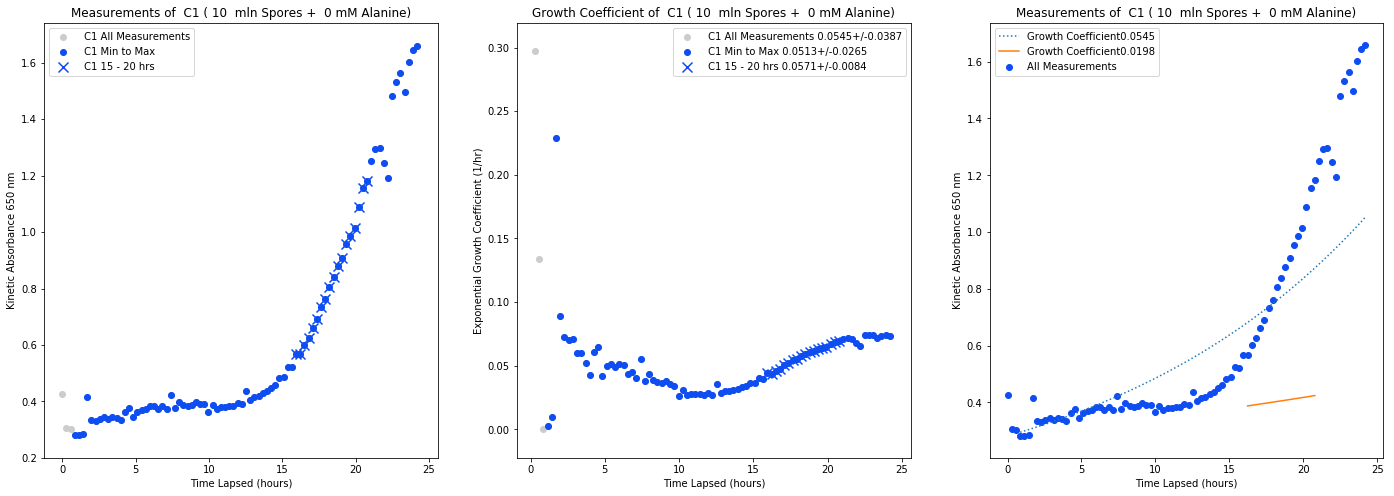

0.0234391812697


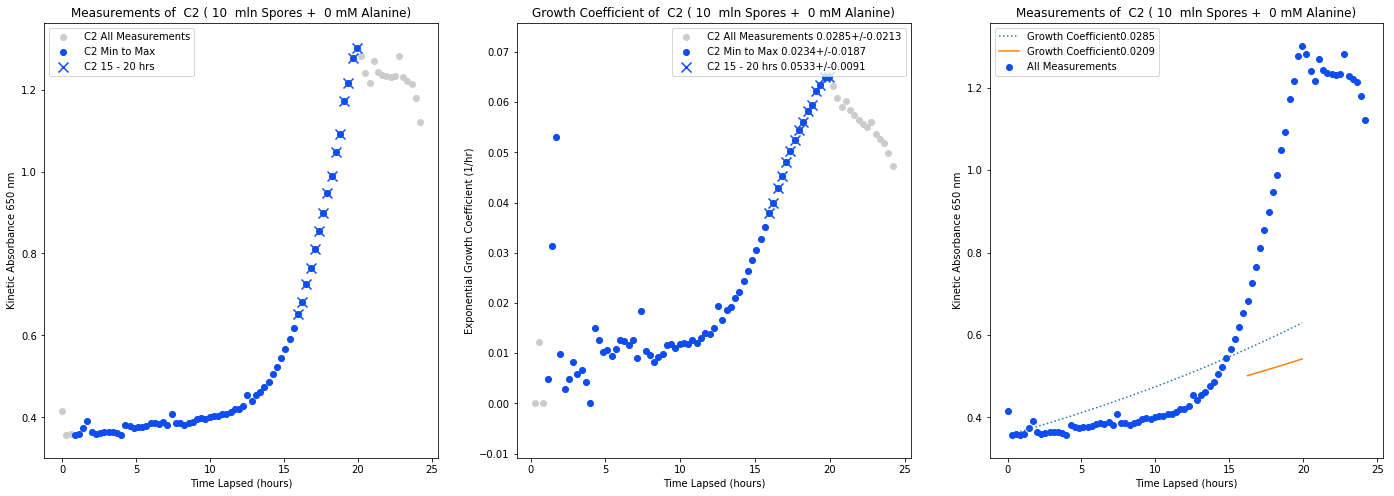

0.0298616323012


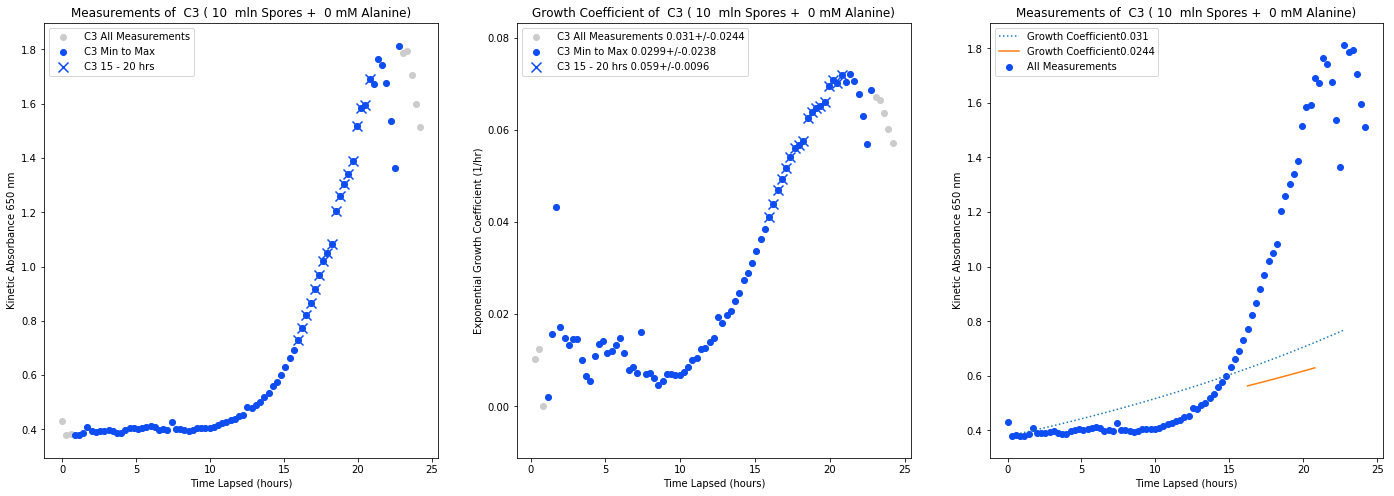

0.00102819377689


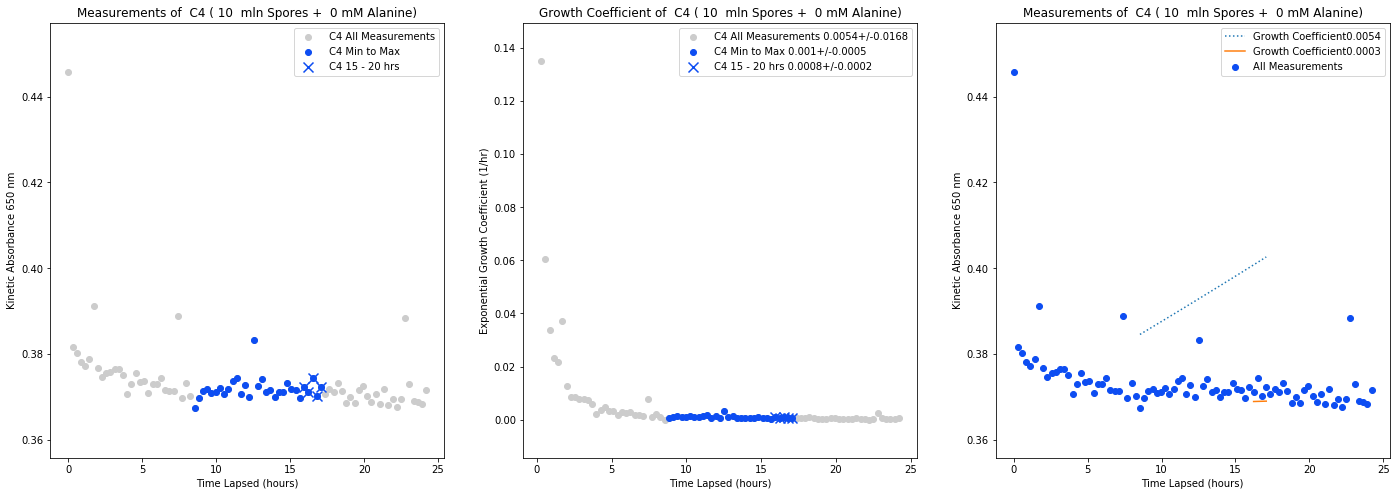

0.0317789481875


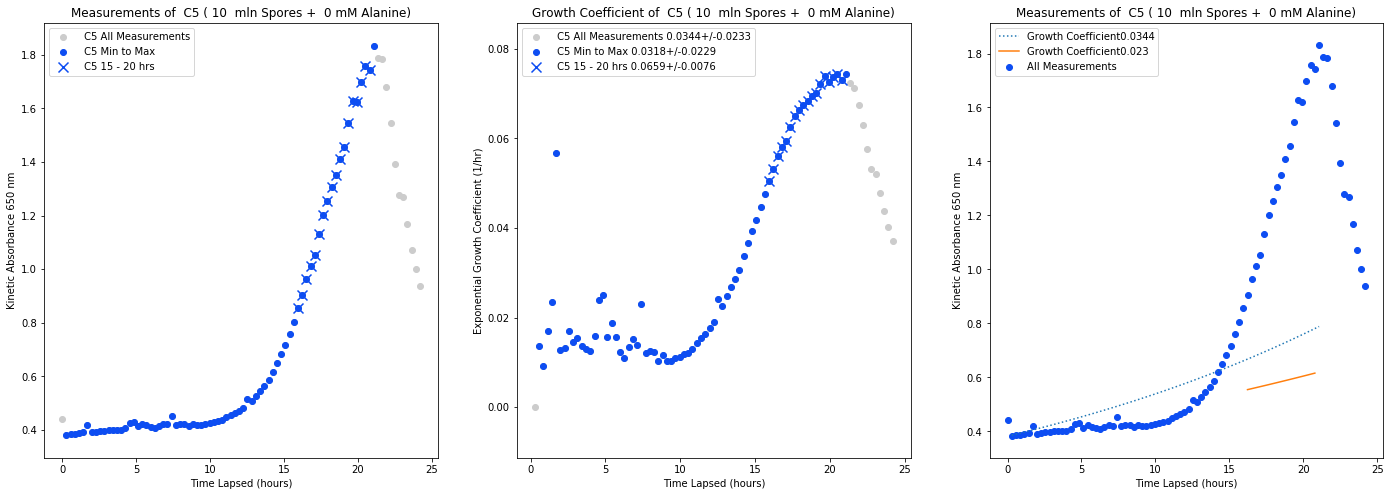

0.0316824103091


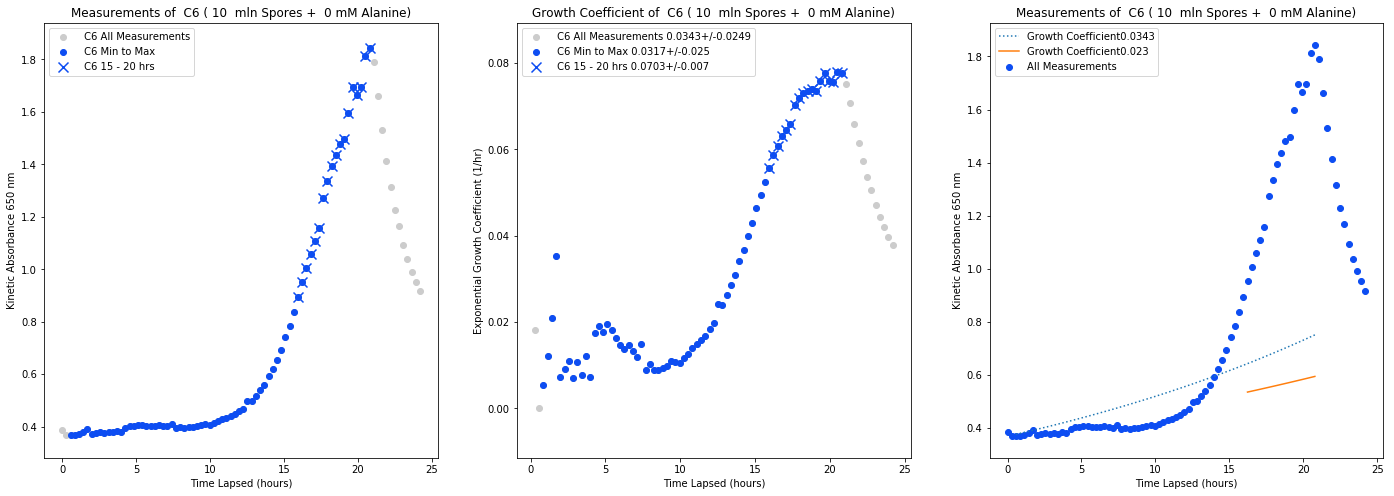

0.0606857448944


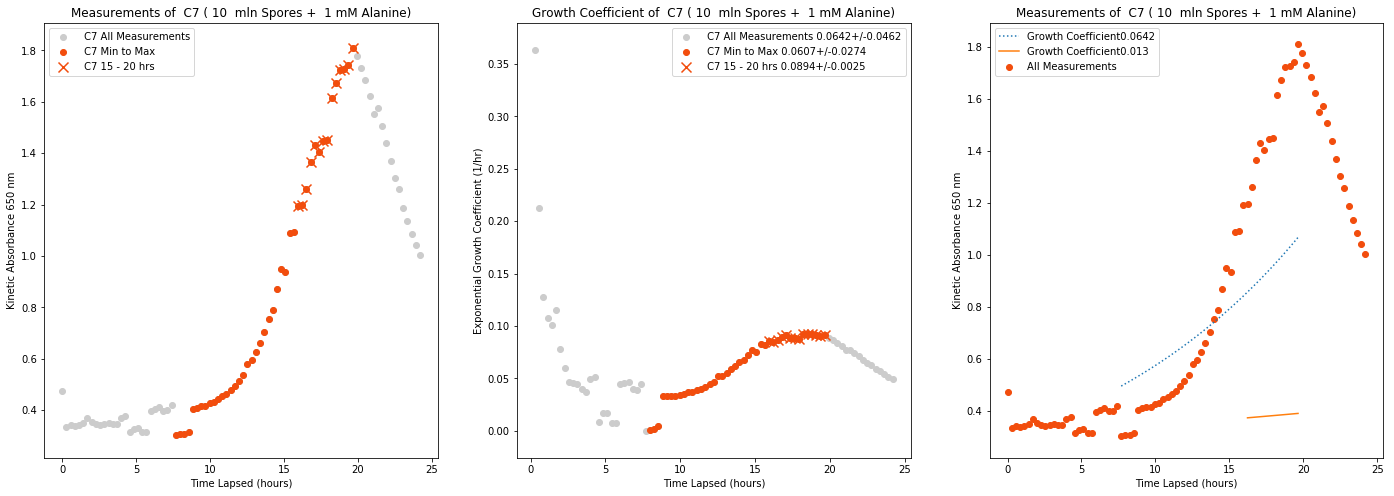

0.0289114007044


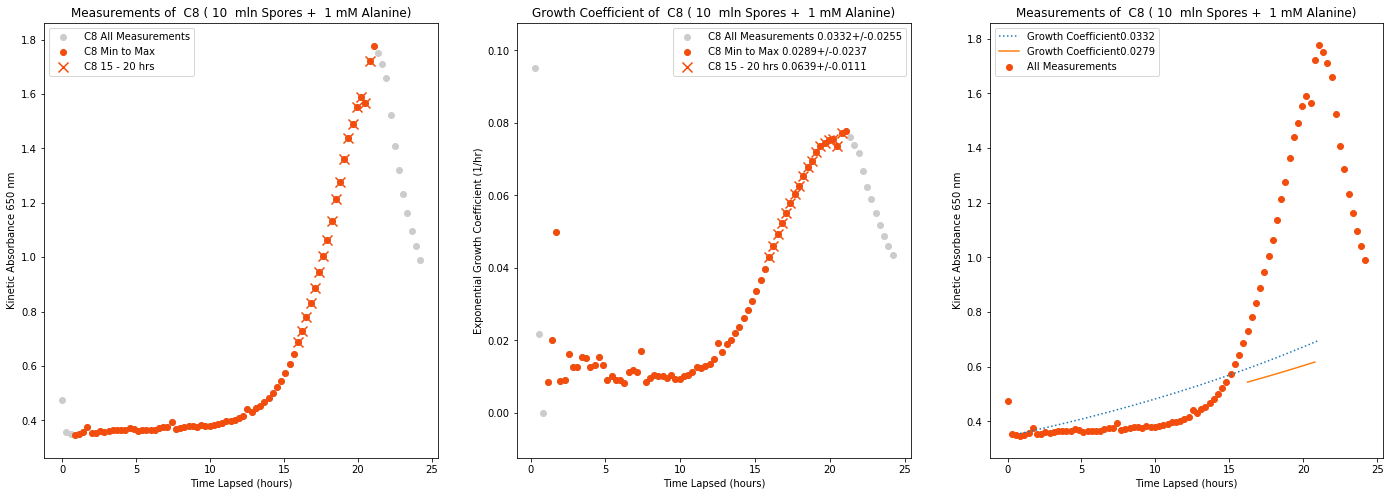

0.0300074210945


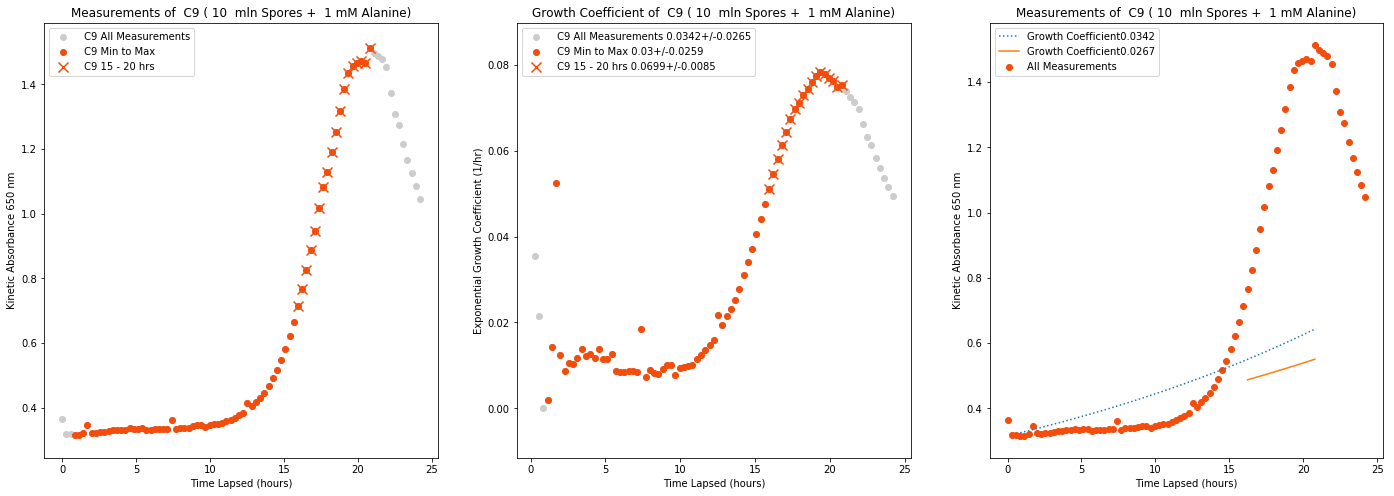

0.0291028128669


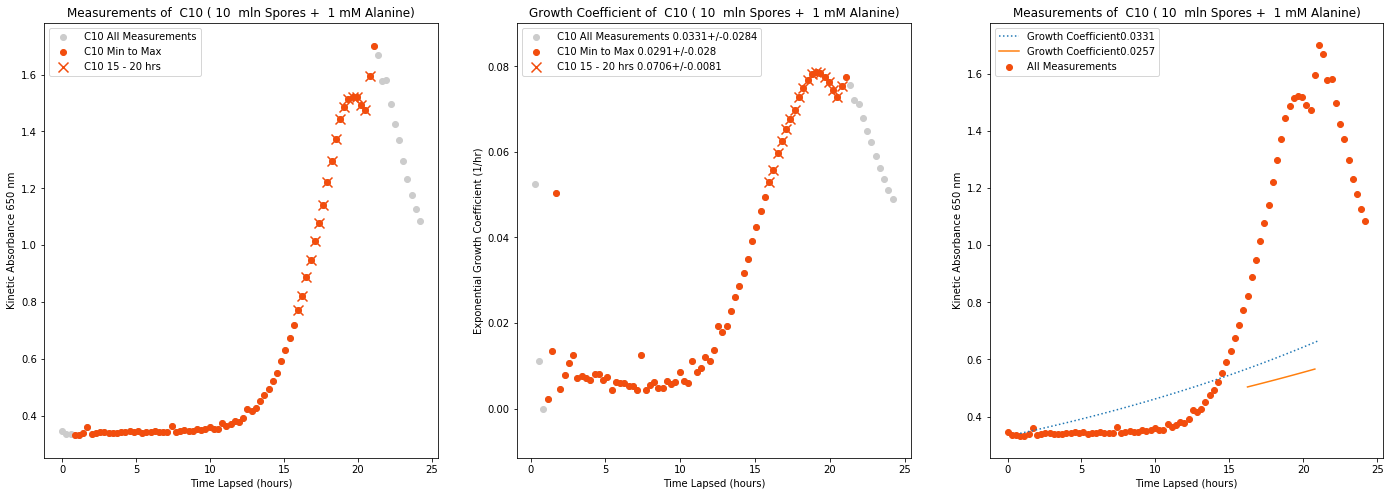

0.0339862425395


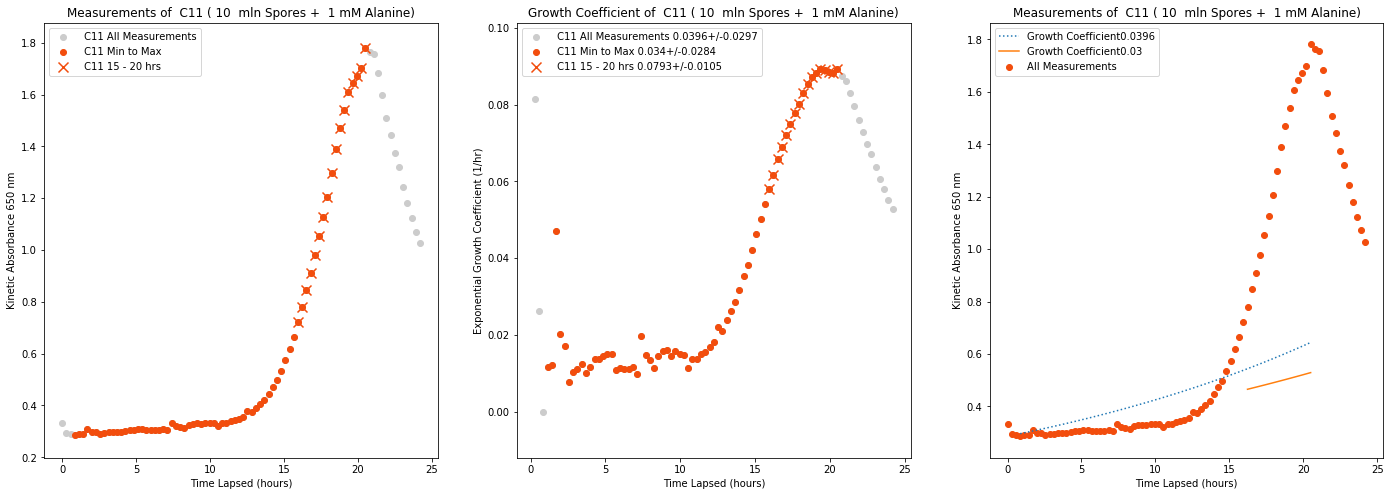

0.028494595129


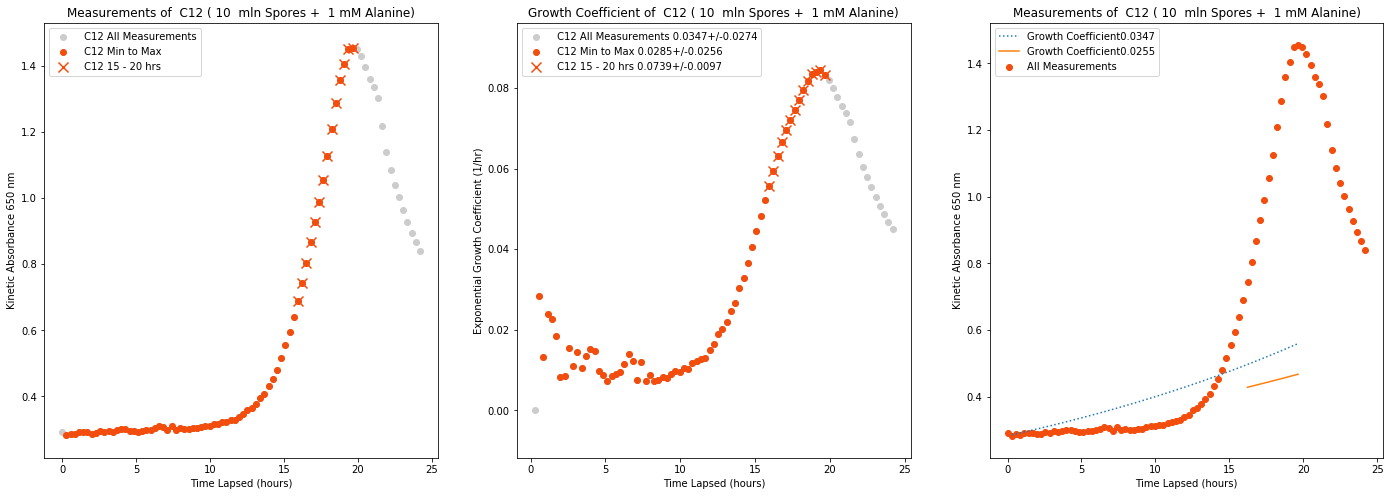

0.033957511779


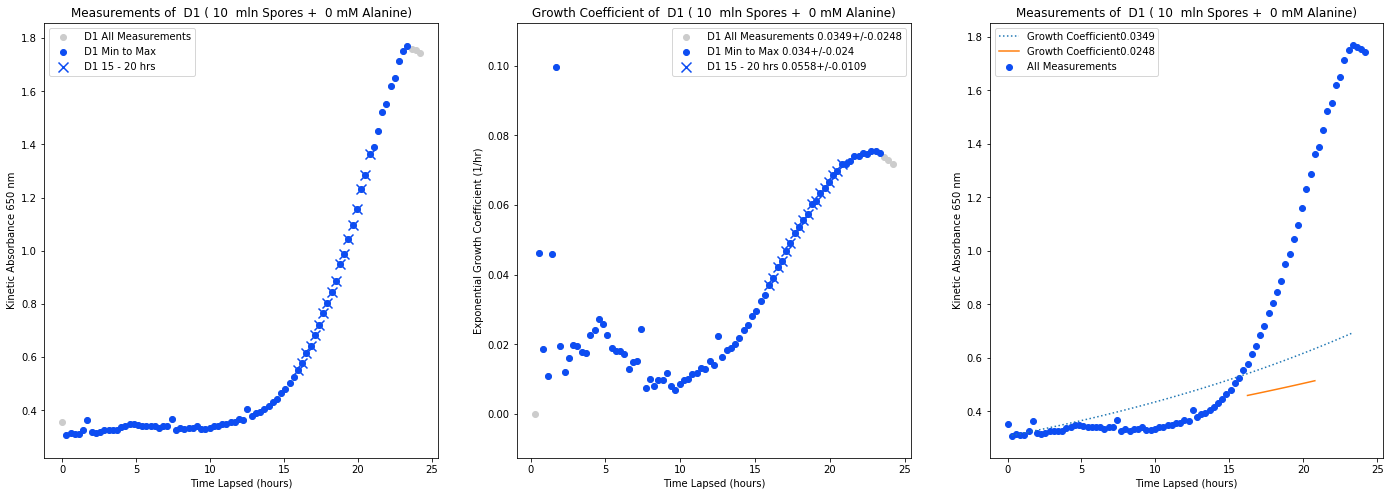

0.0448717051348


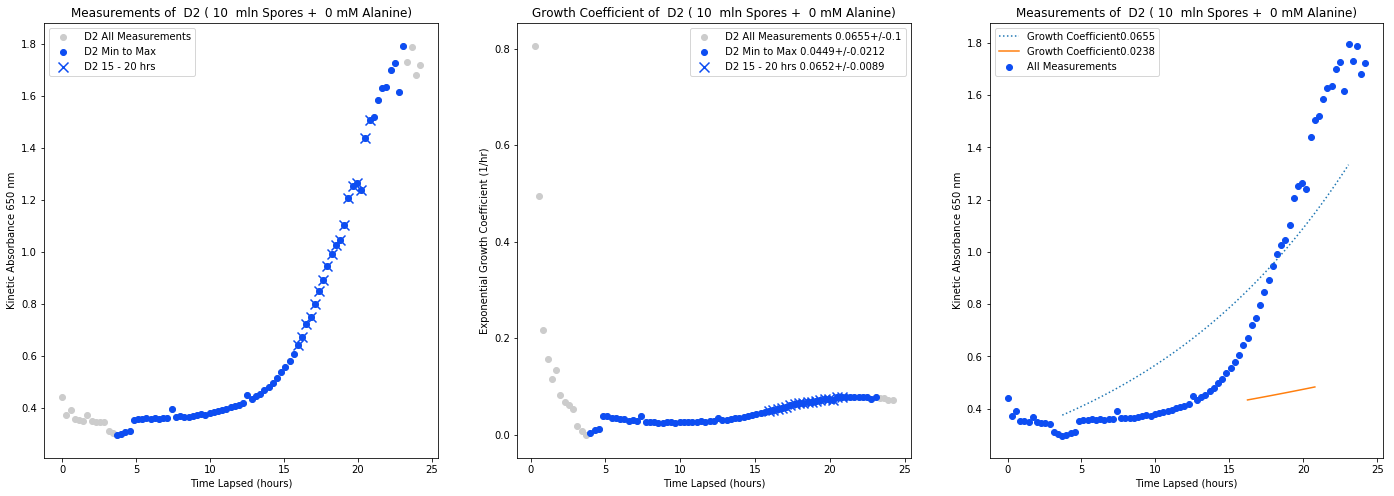

0.0346644929447


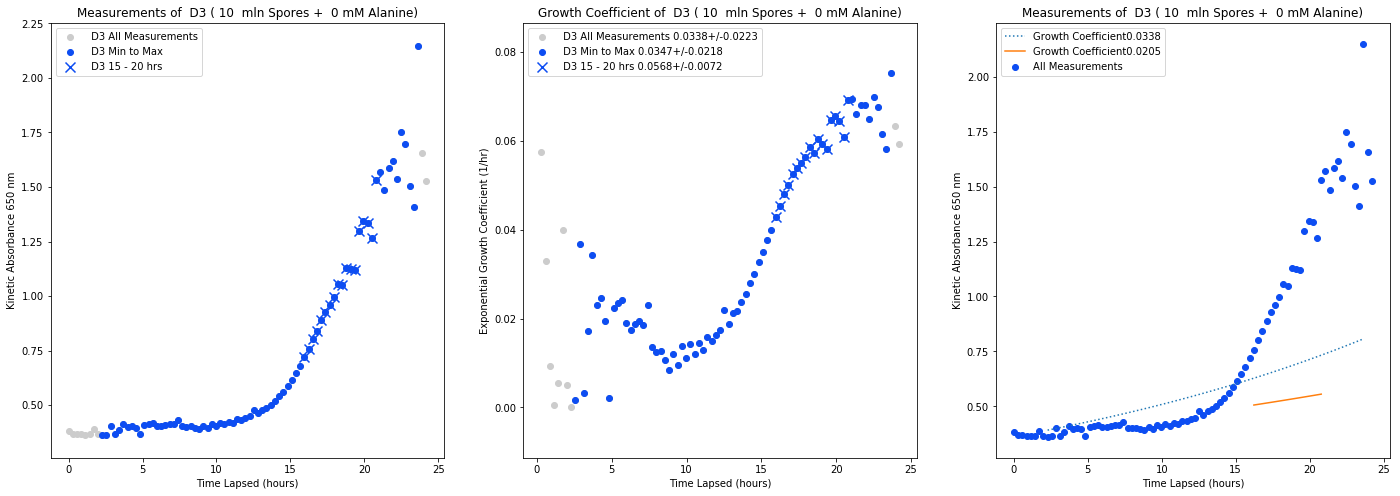

0.0285141868507


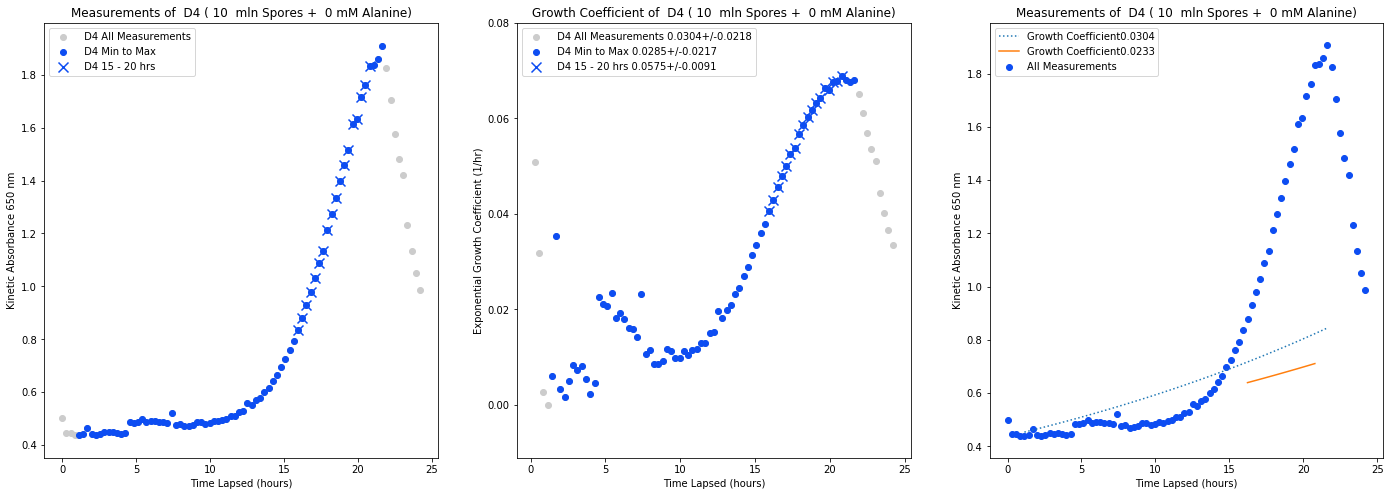

0.0320403870087


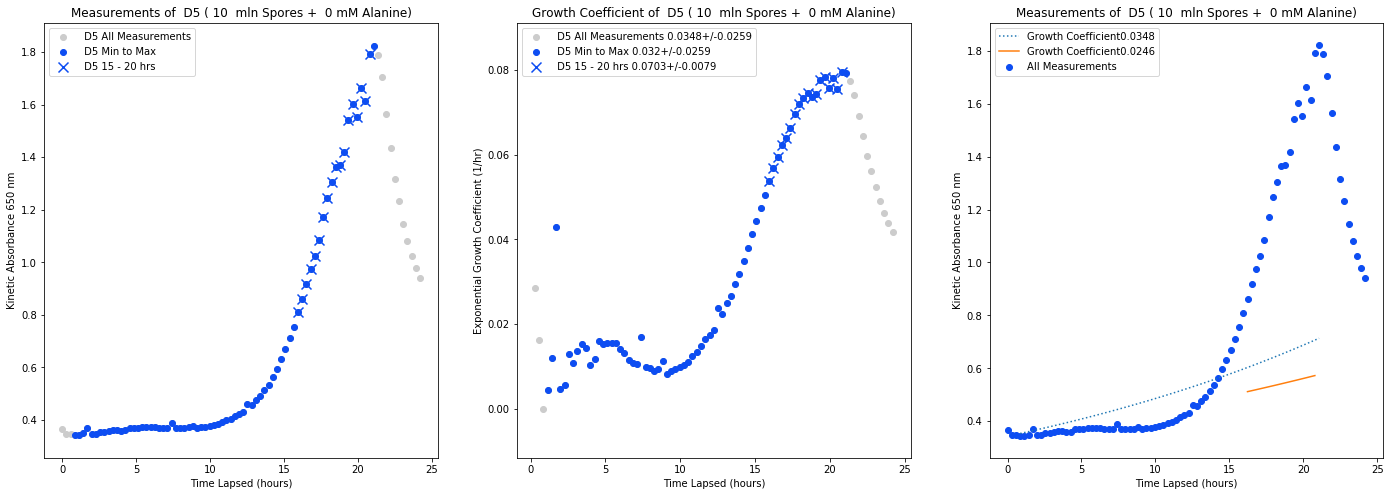

0.0330604482066


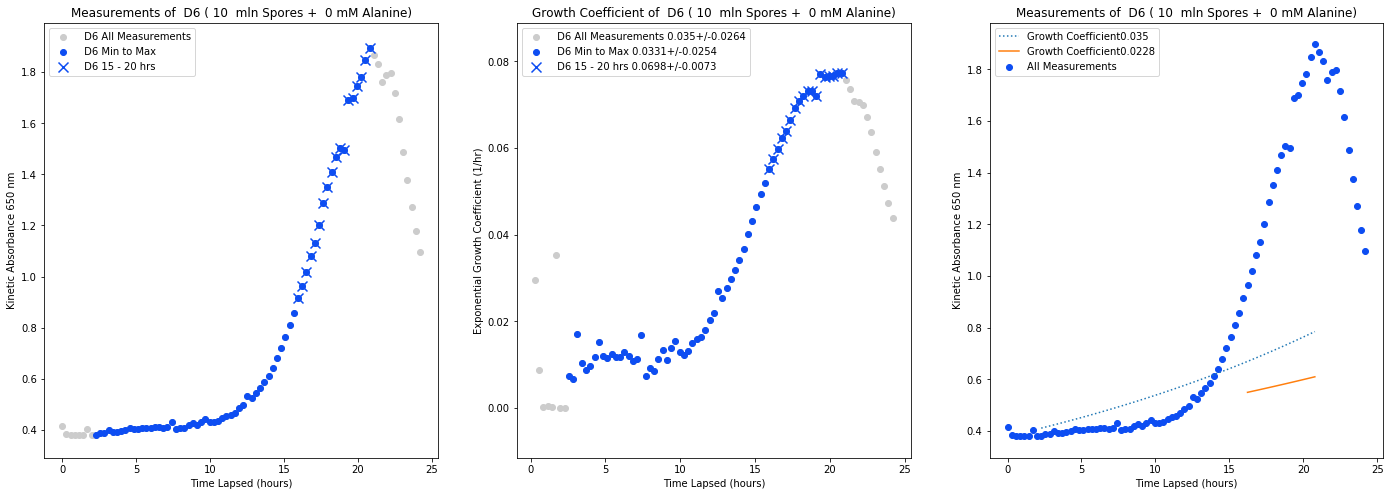

0.00114252245118


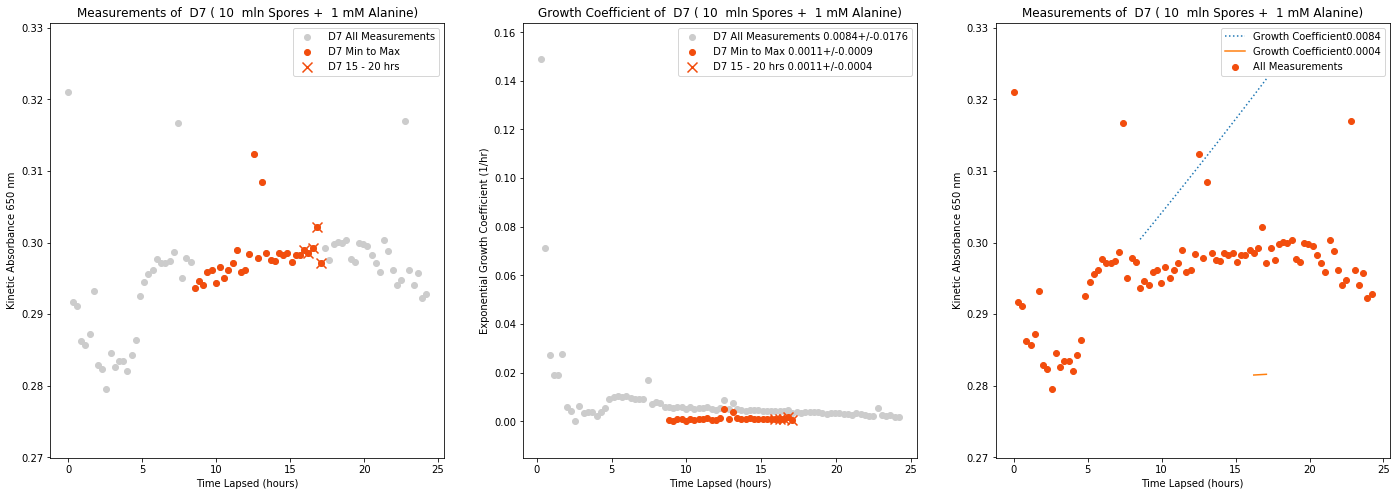

0.0314565837832


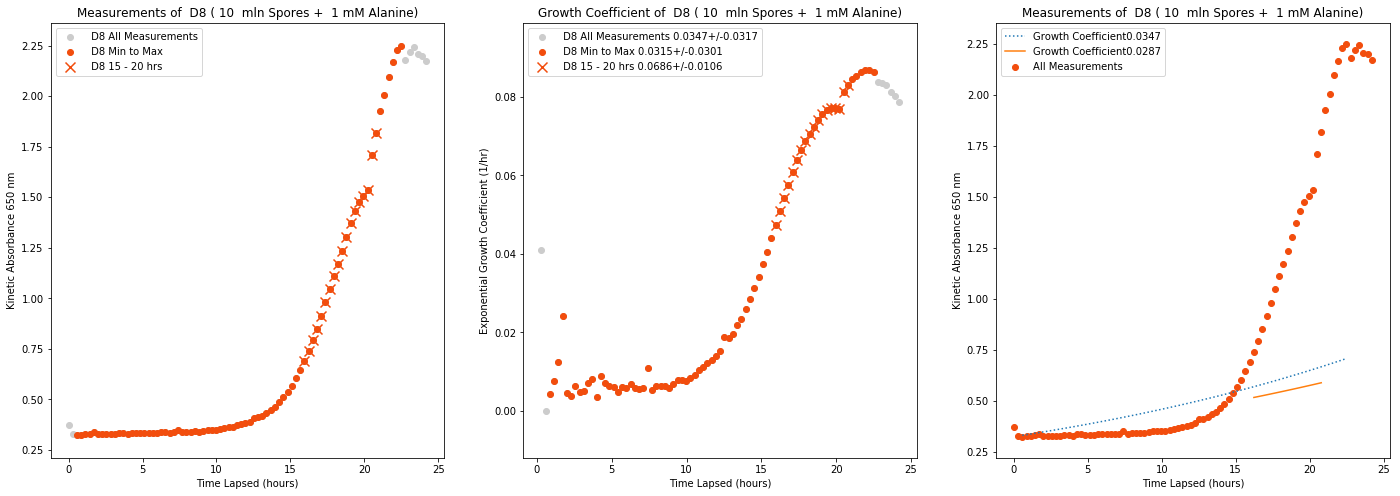

0.033109119906


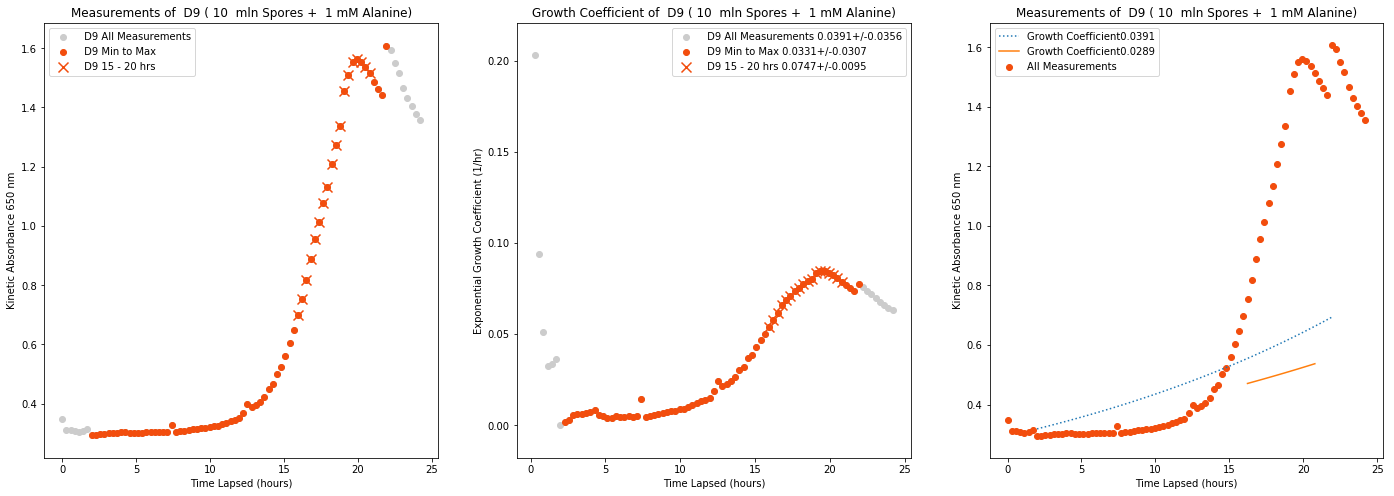

0.0275215504885


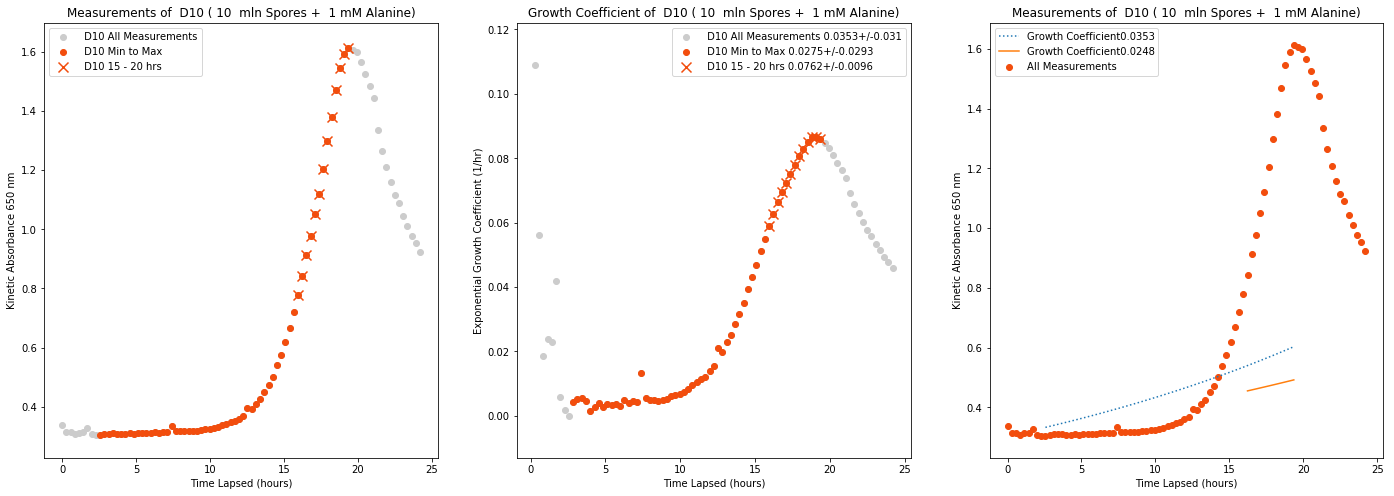

0.0387606533887


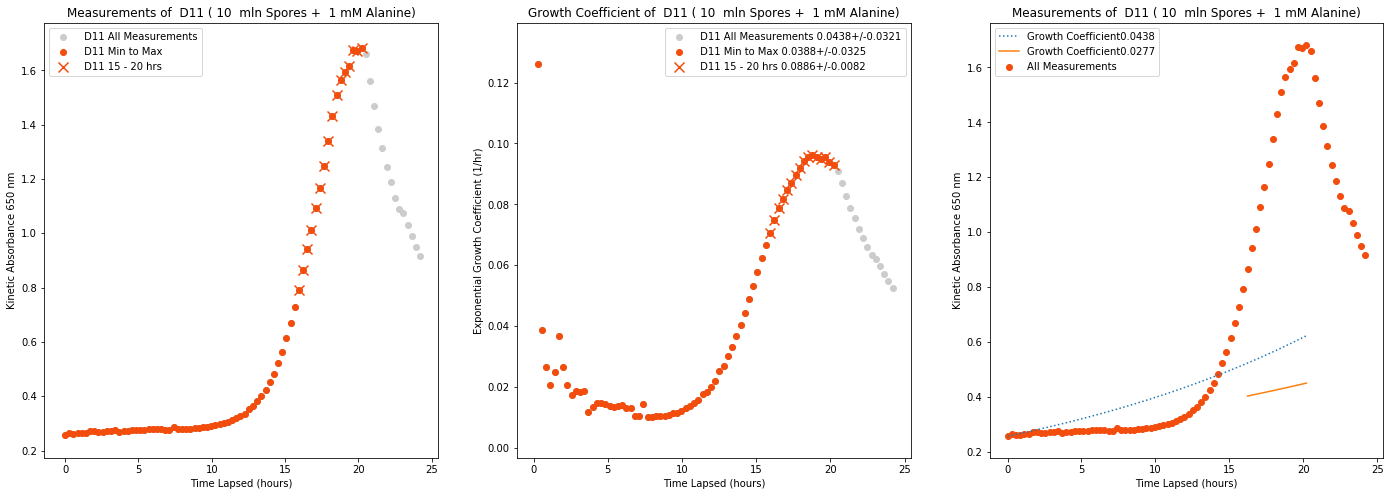

0.0342381262581


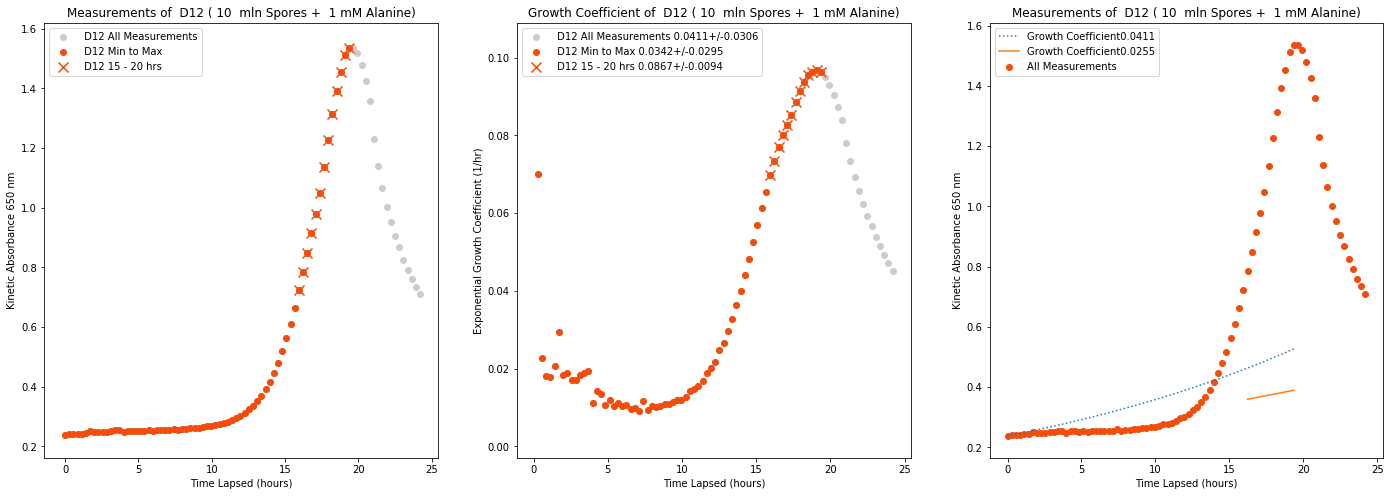

0.0250876242364


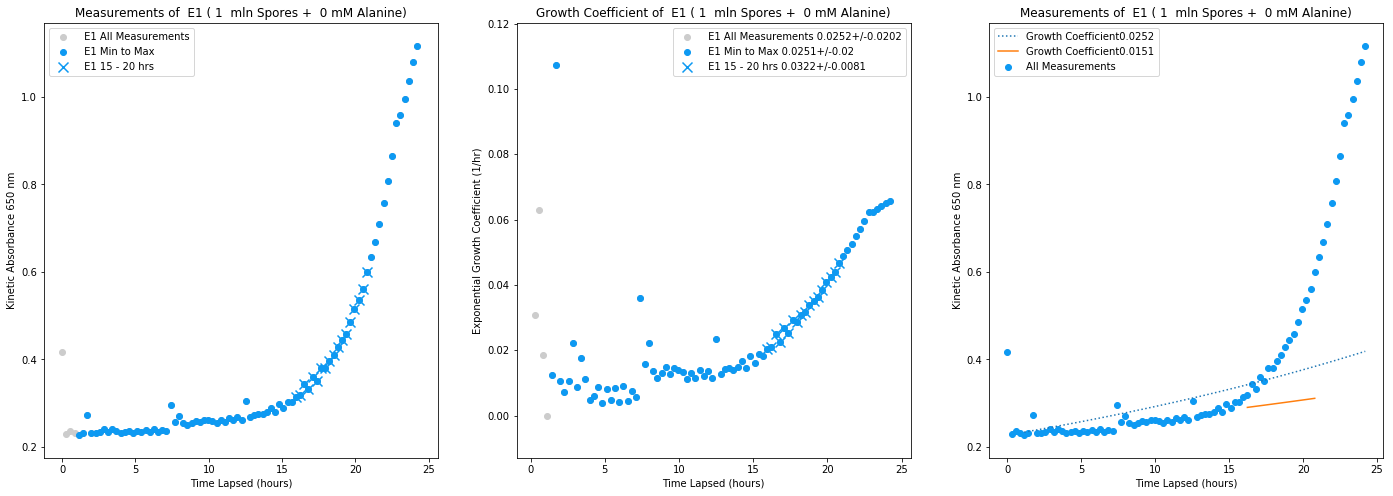

0.0244846427795


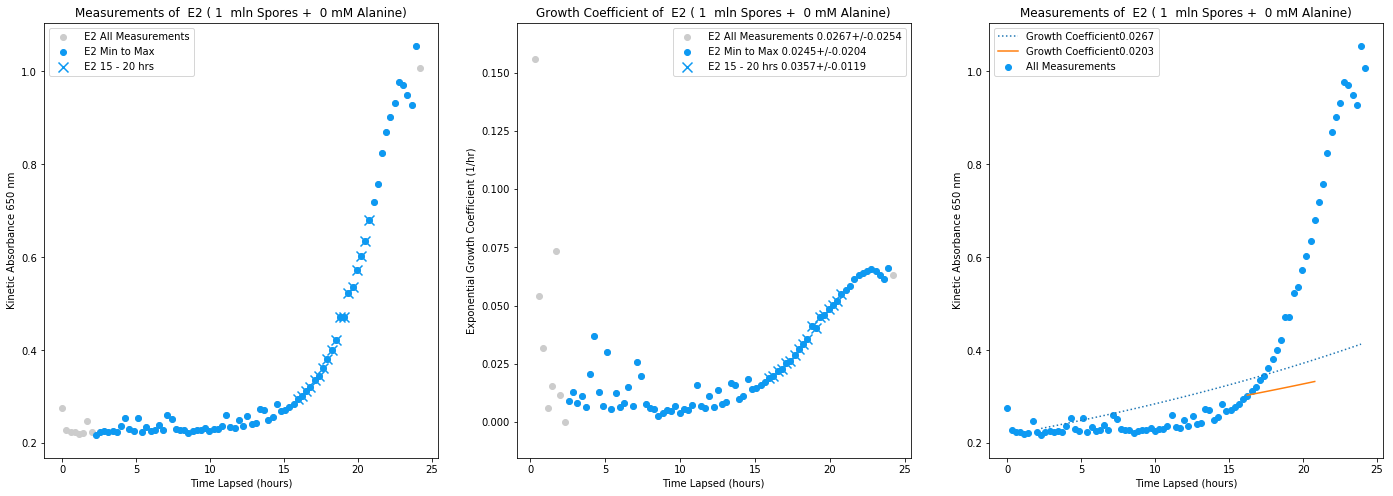

0.0299913693995


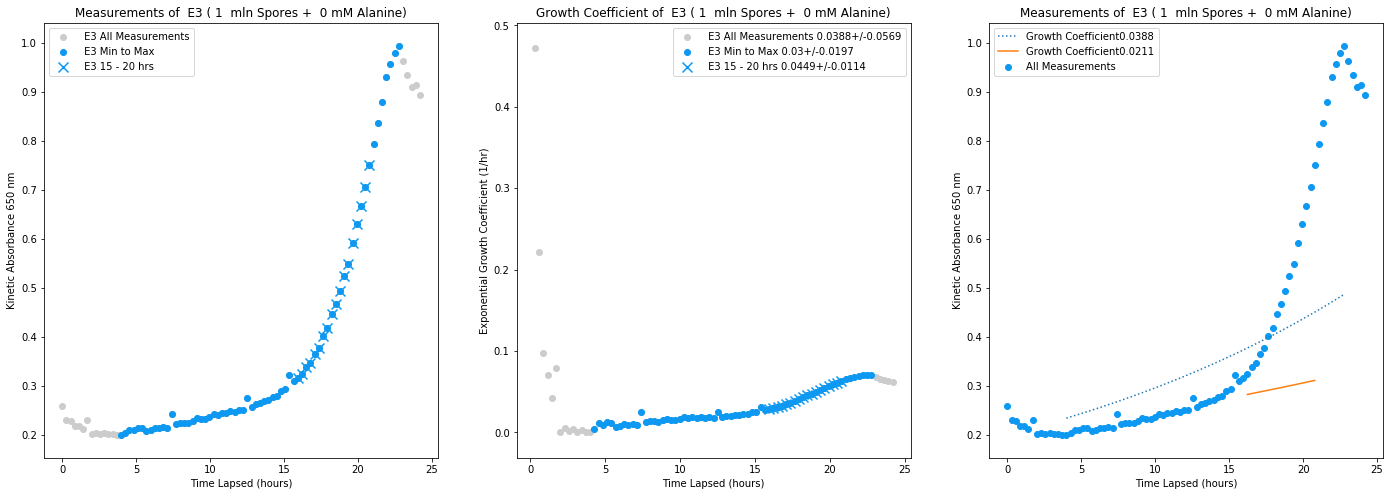

0.0231934295646


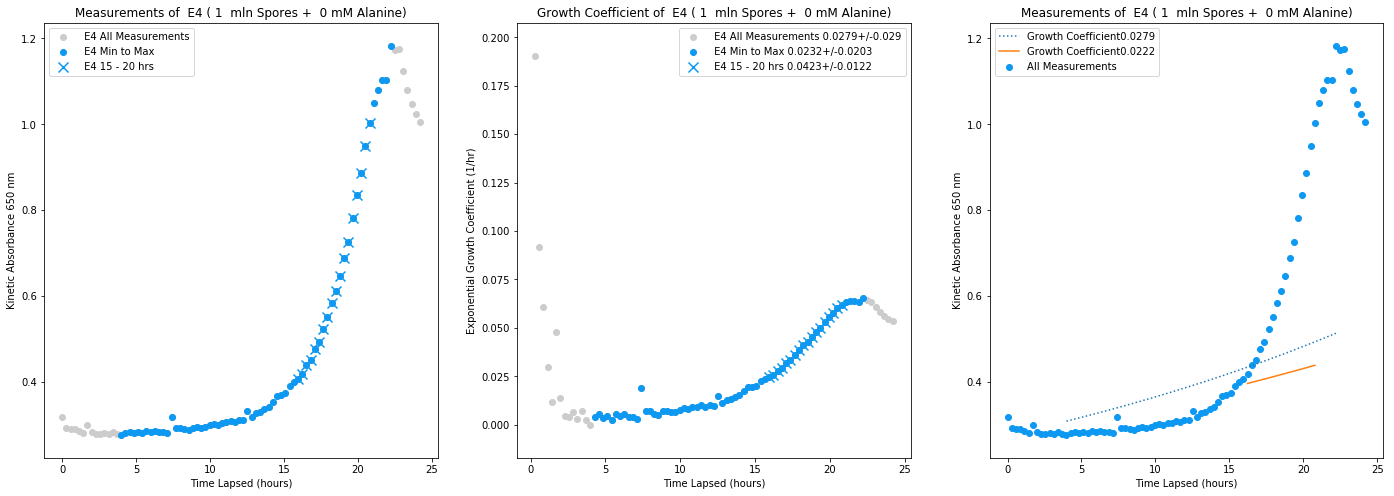

0.0195479182512


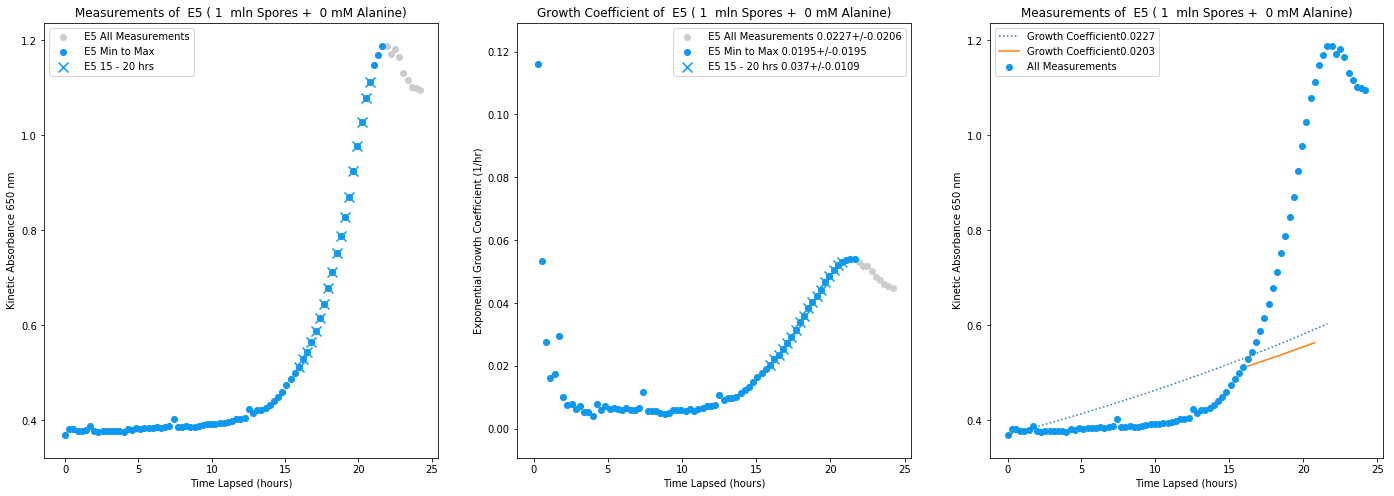

0.0257586925357


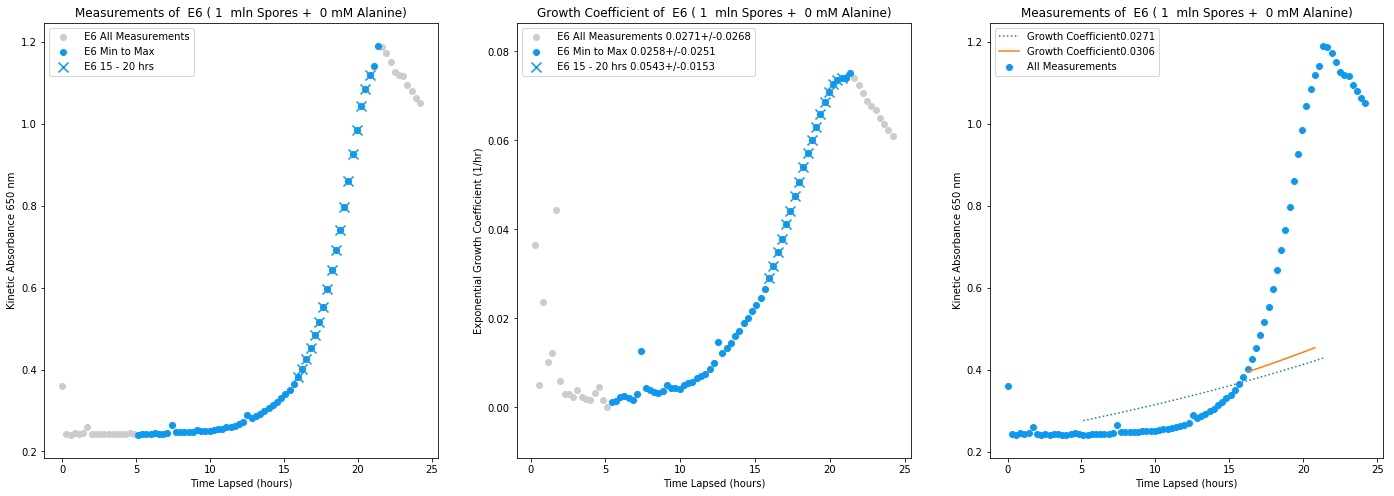

0.0211969590441


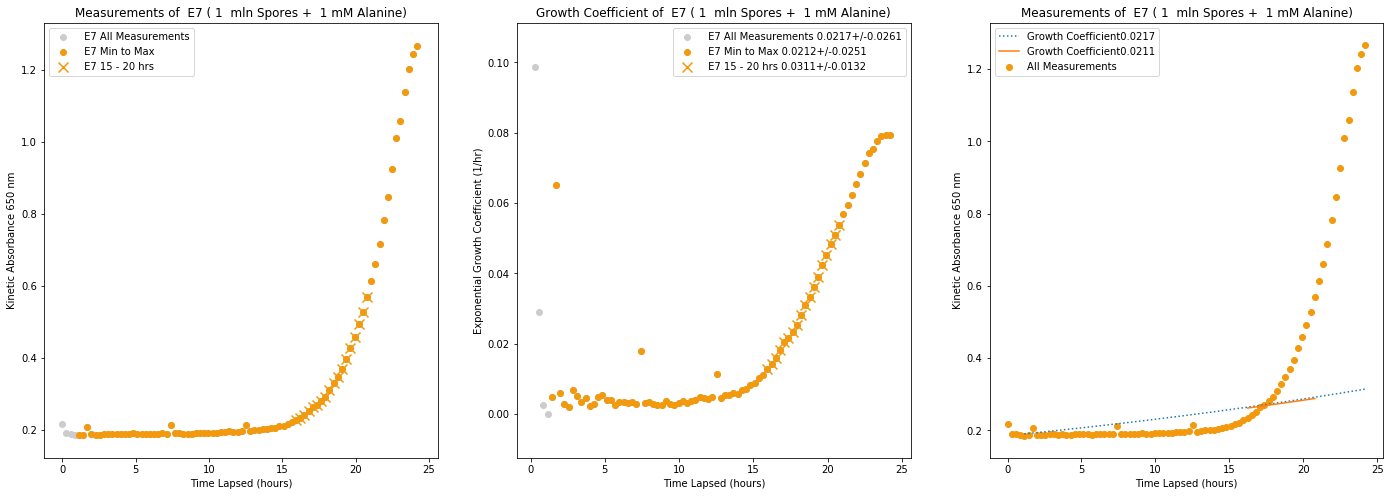

0.0210758359733


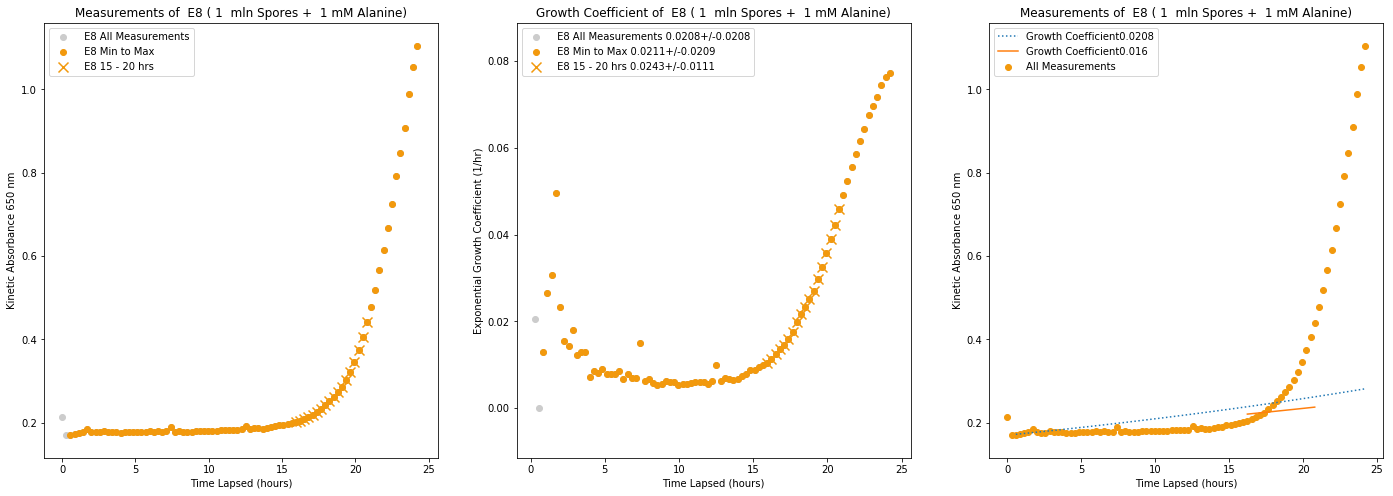

0.0288423001772


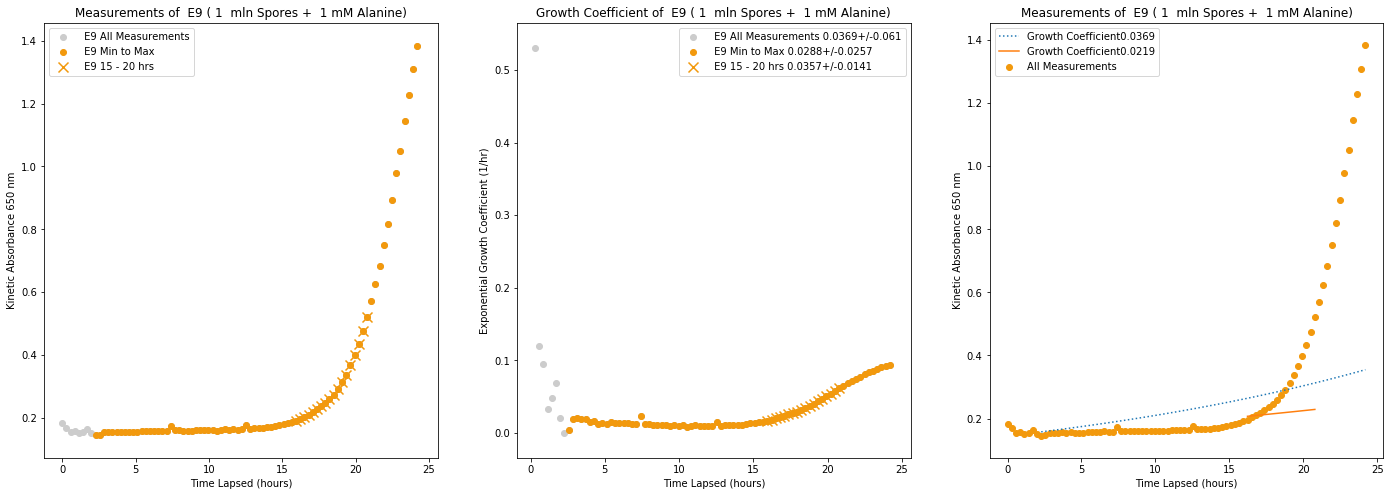

0.0202571238667


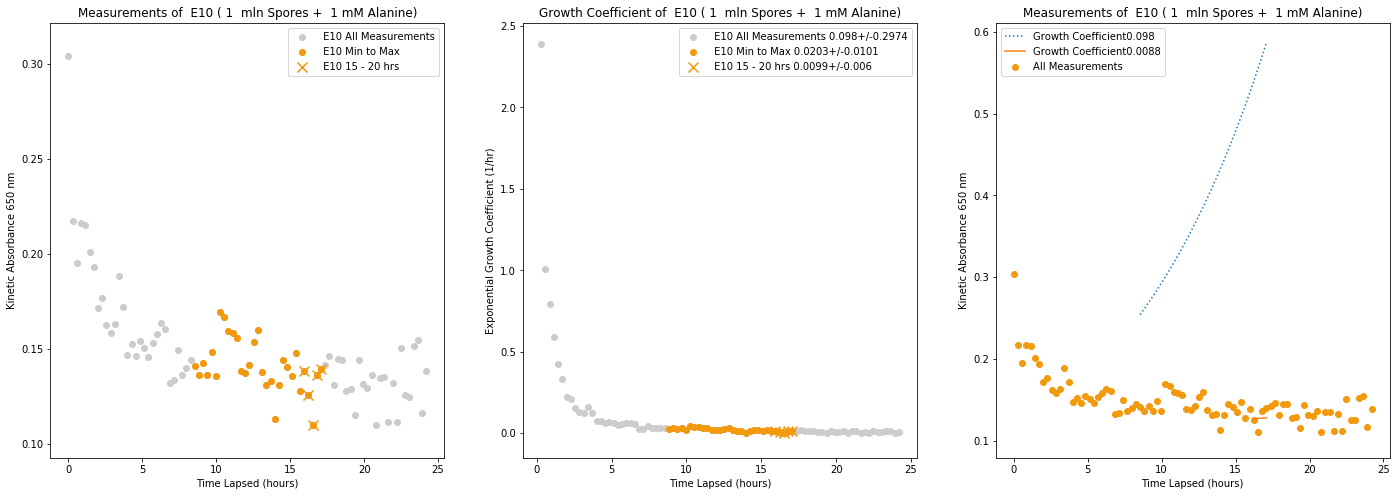

0.0466609512052


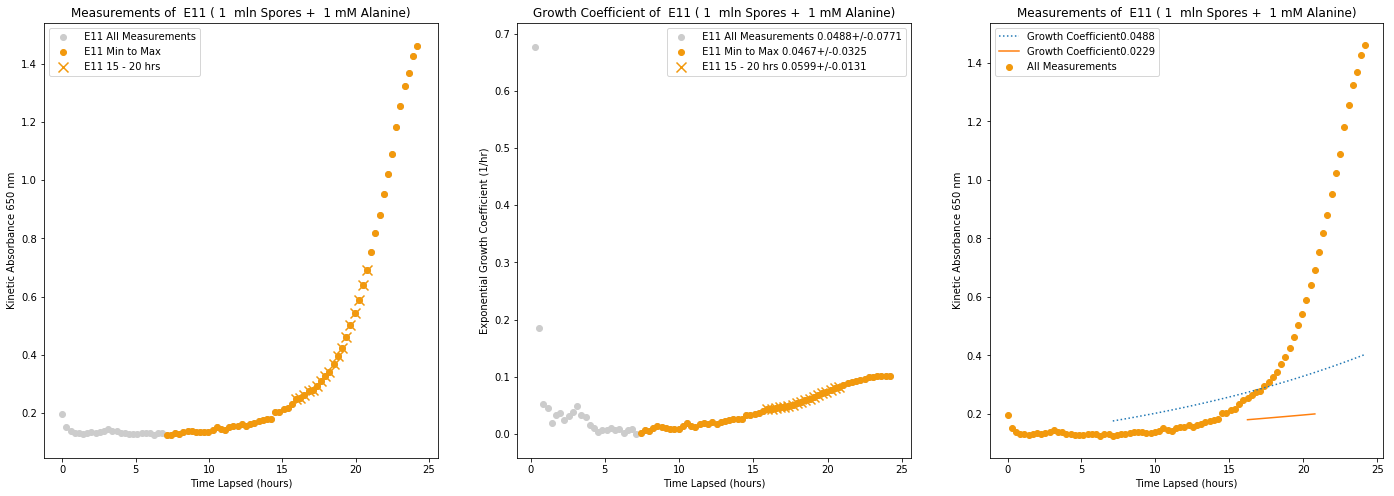

0.0437484163816


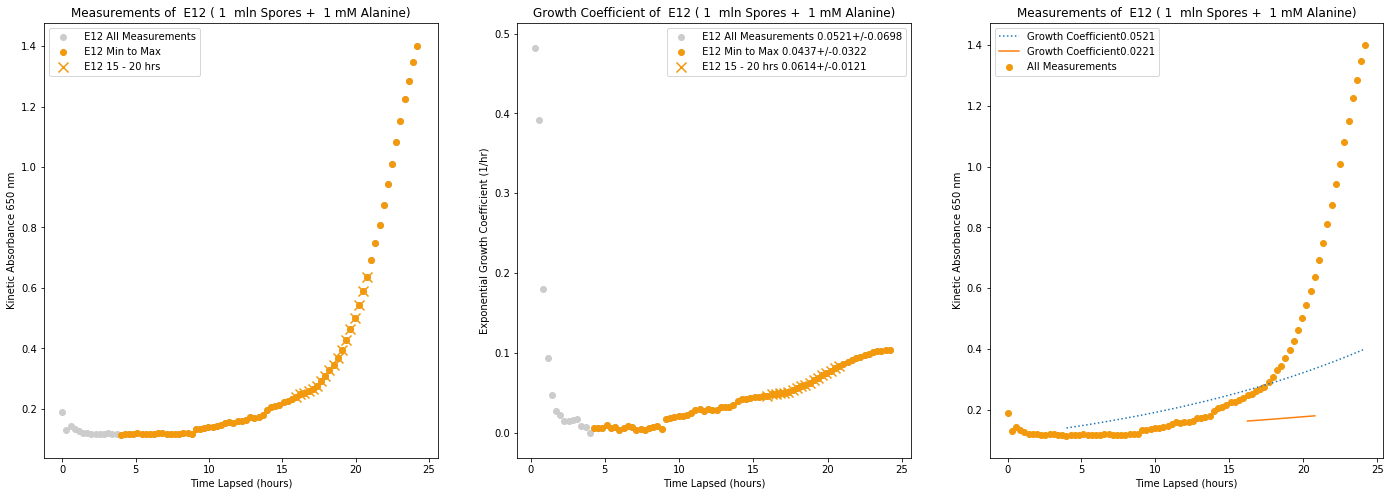

0.028692427286


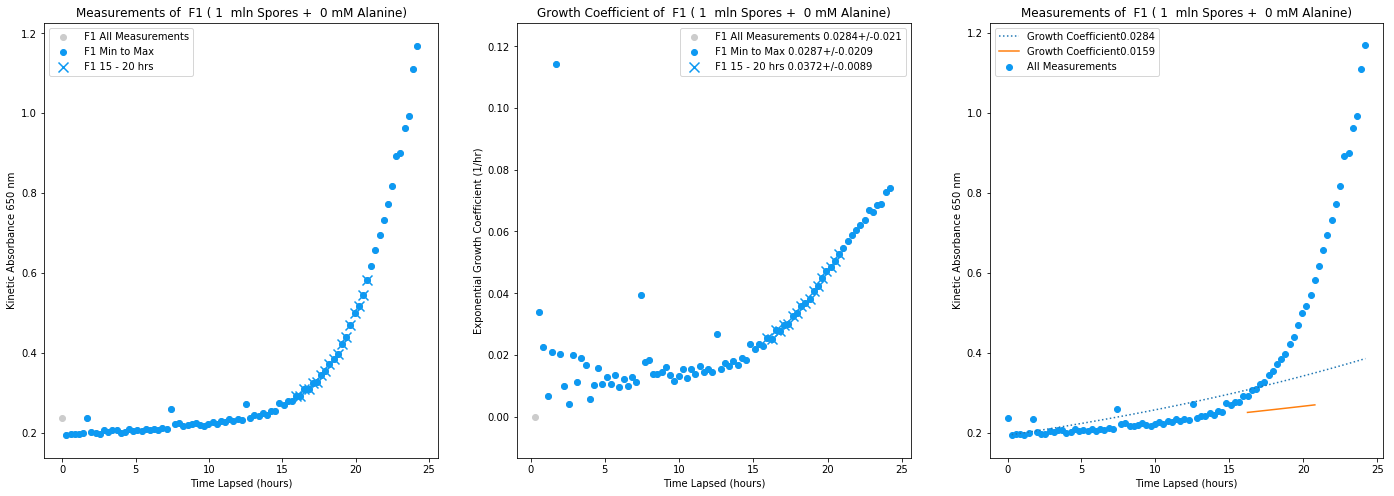

0.0238148067768


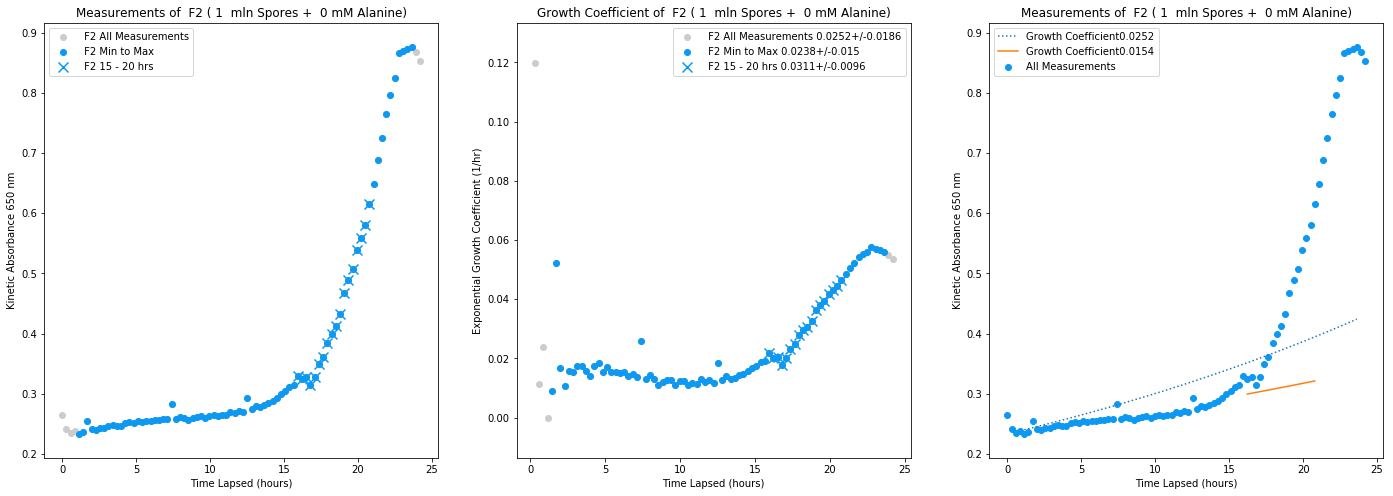

0.0271330800785


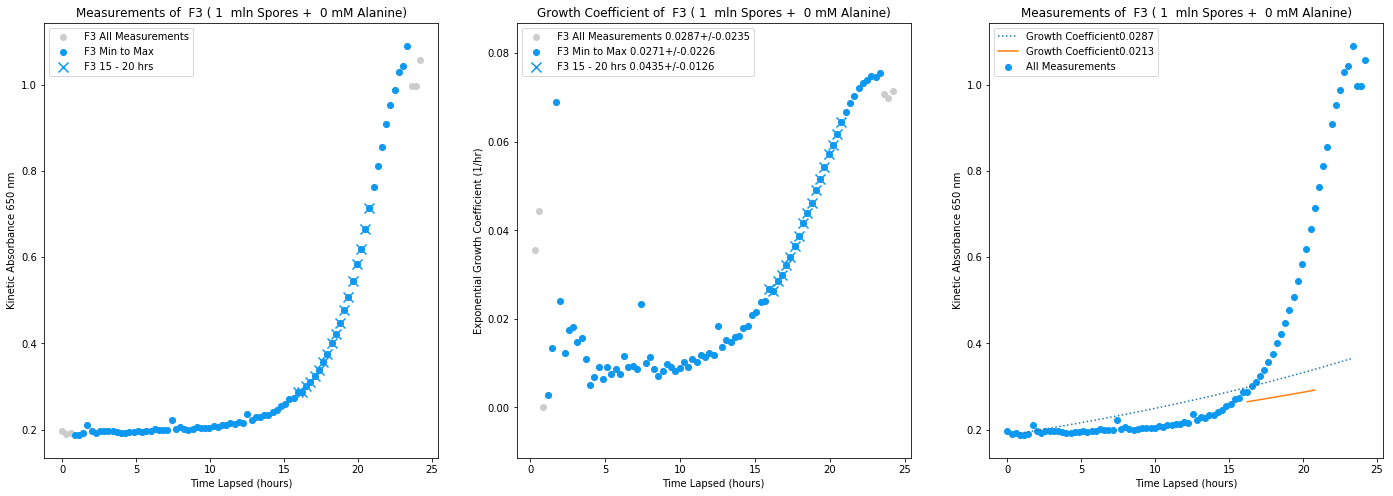

0.026292247152


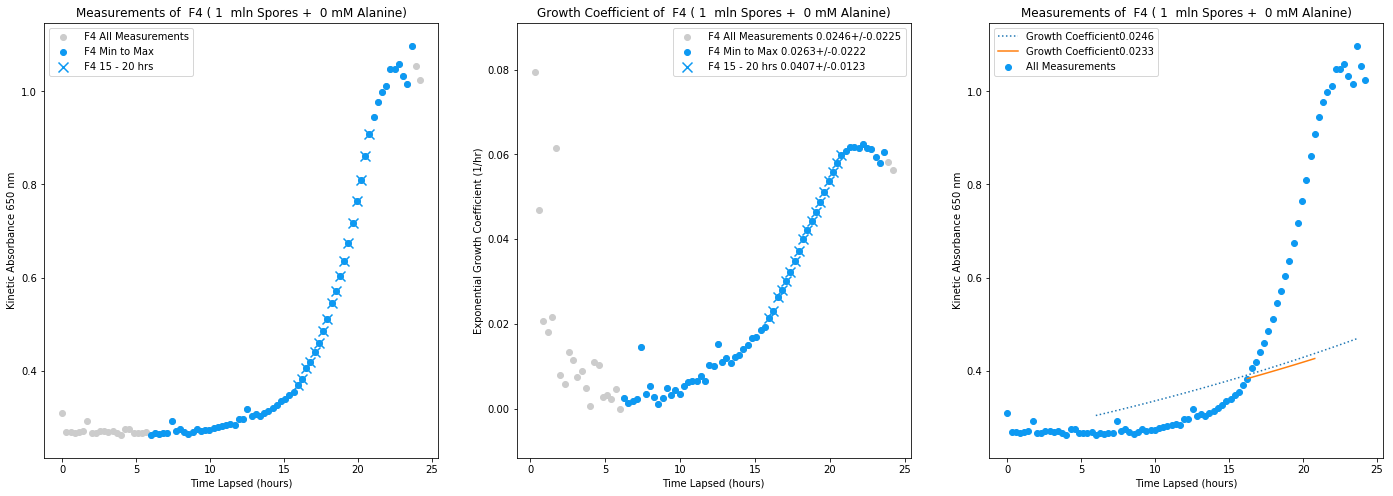

0.0394715765099


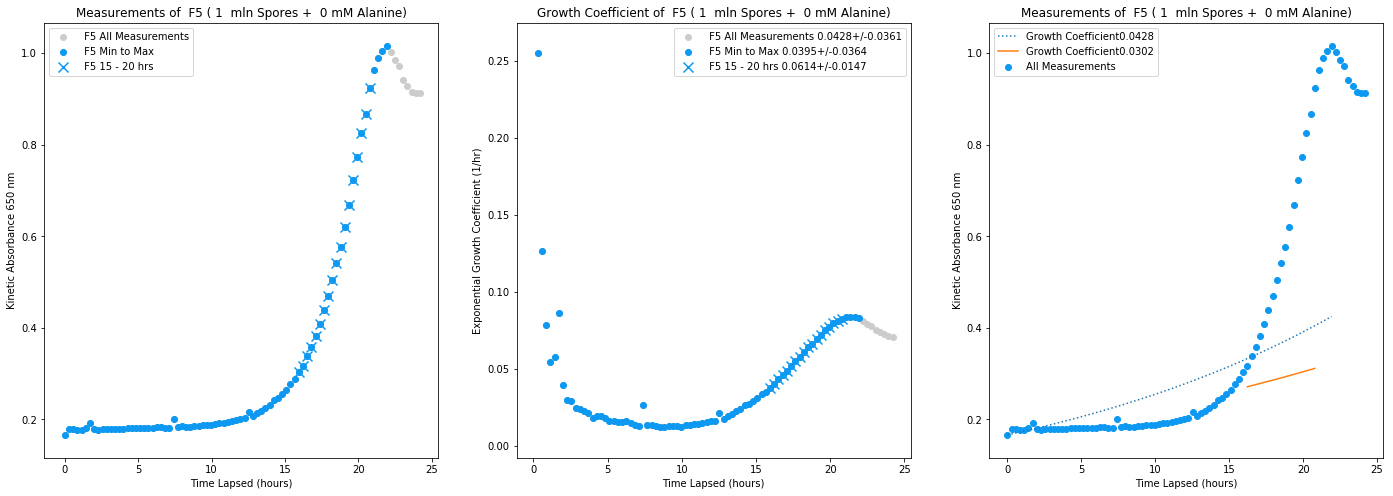

0.0235081976313


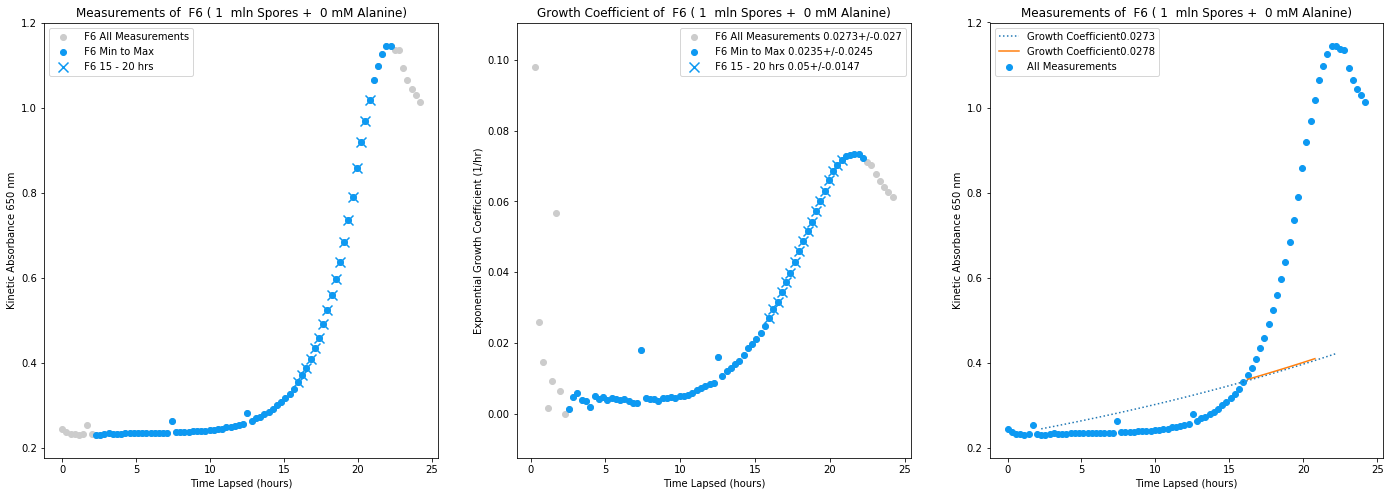

0.017143670194


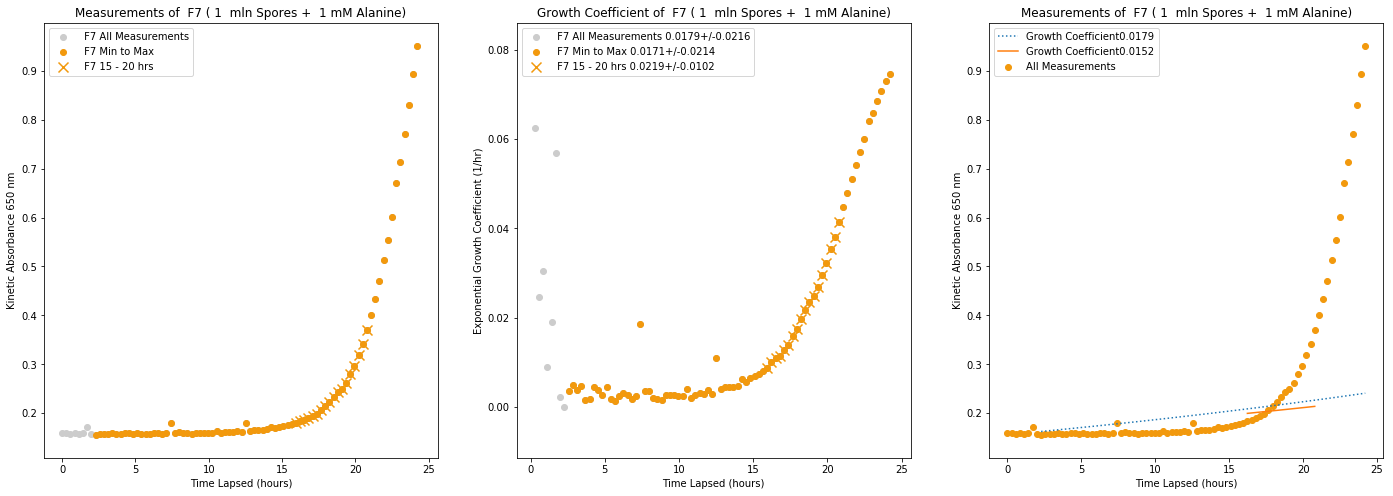

0.0363761455333


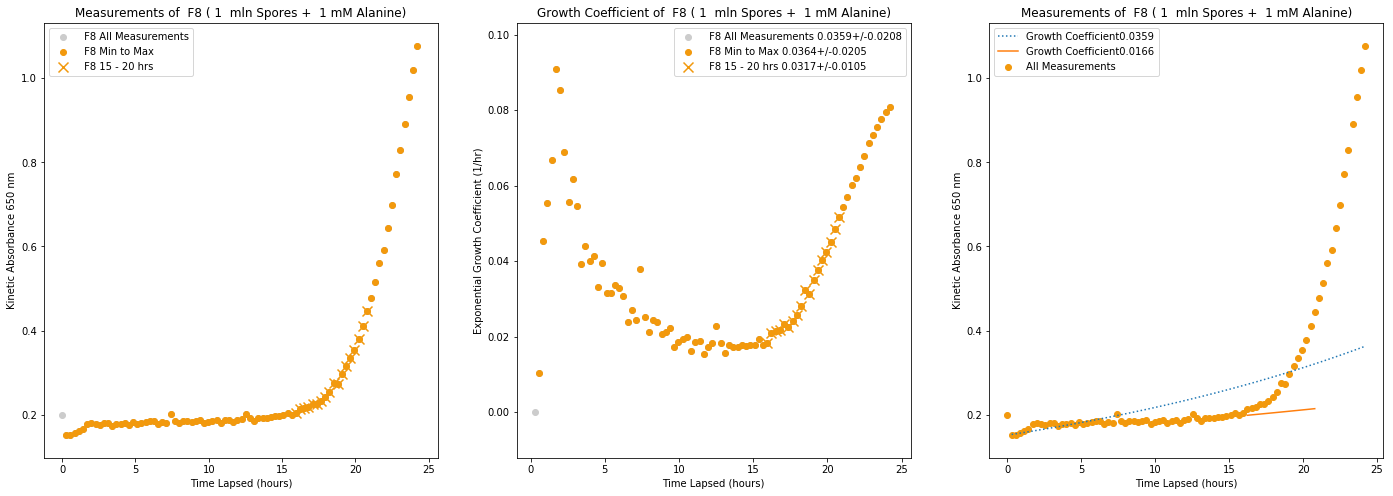

0.0337143868213


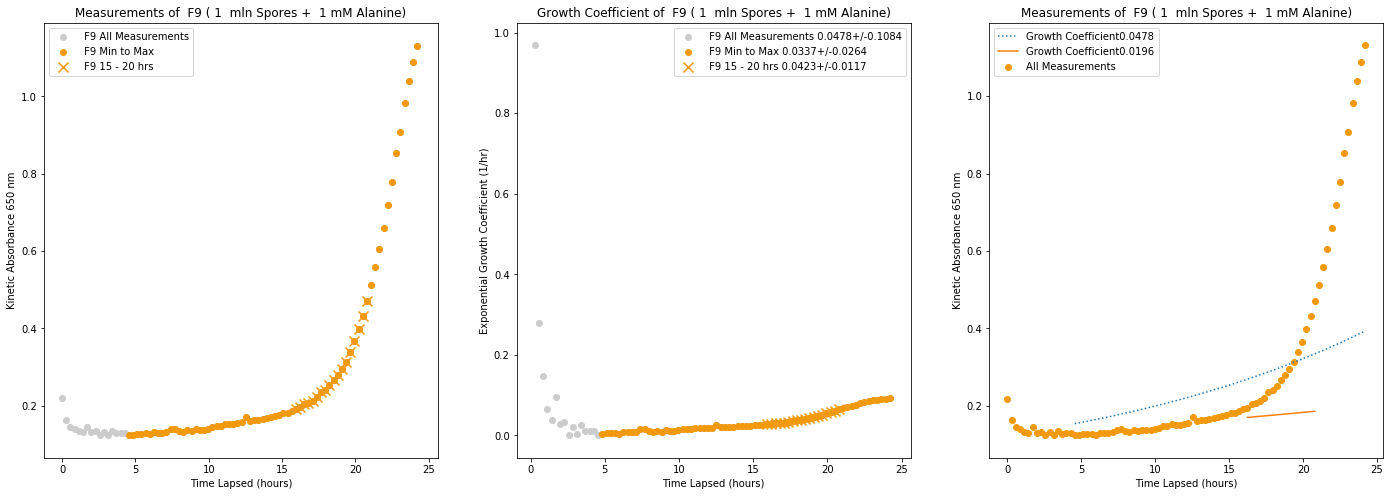

0.0333762450142


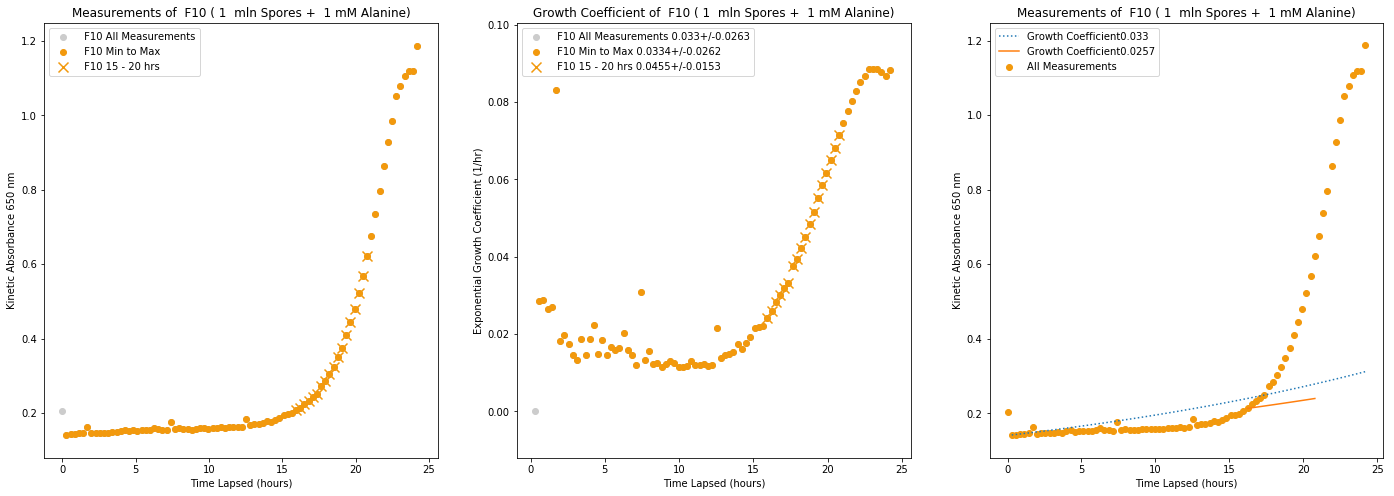

0.0387841452397


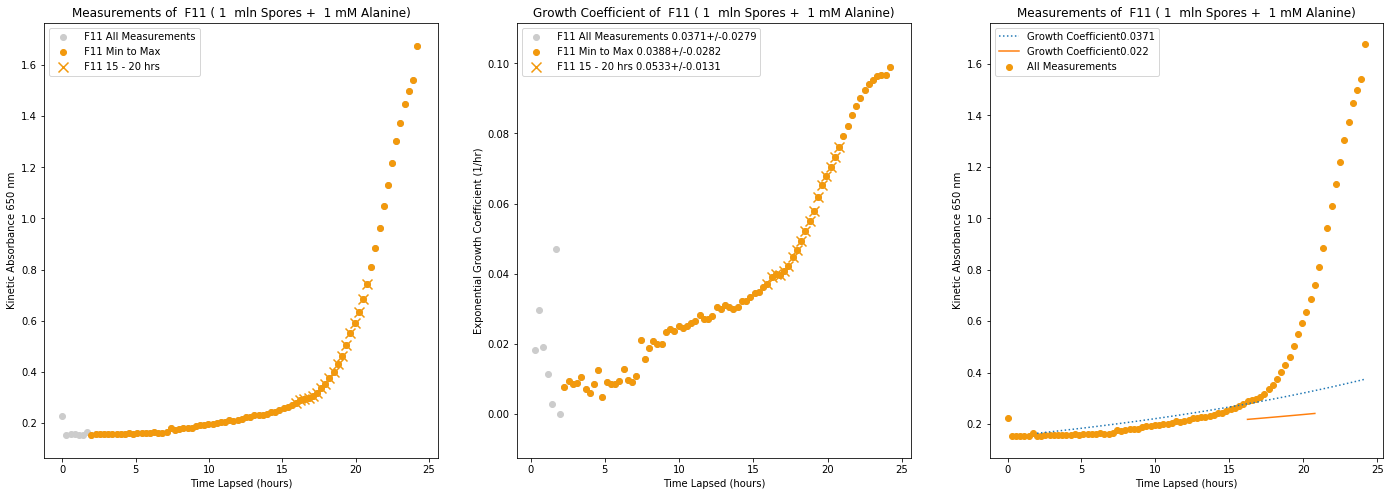

0.0381745260491


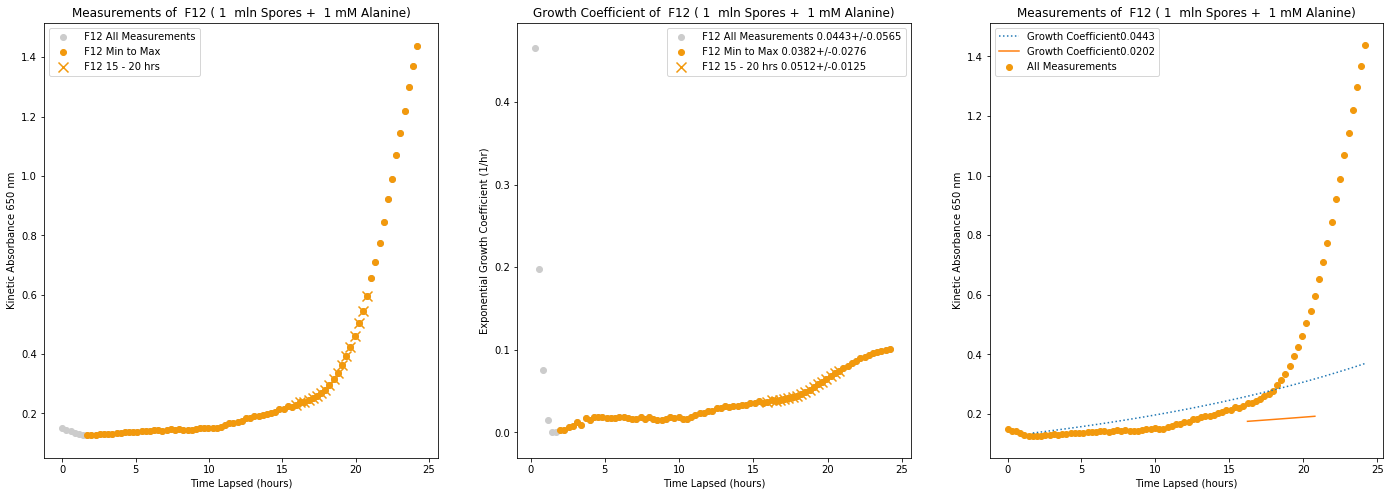

0.0138370975158


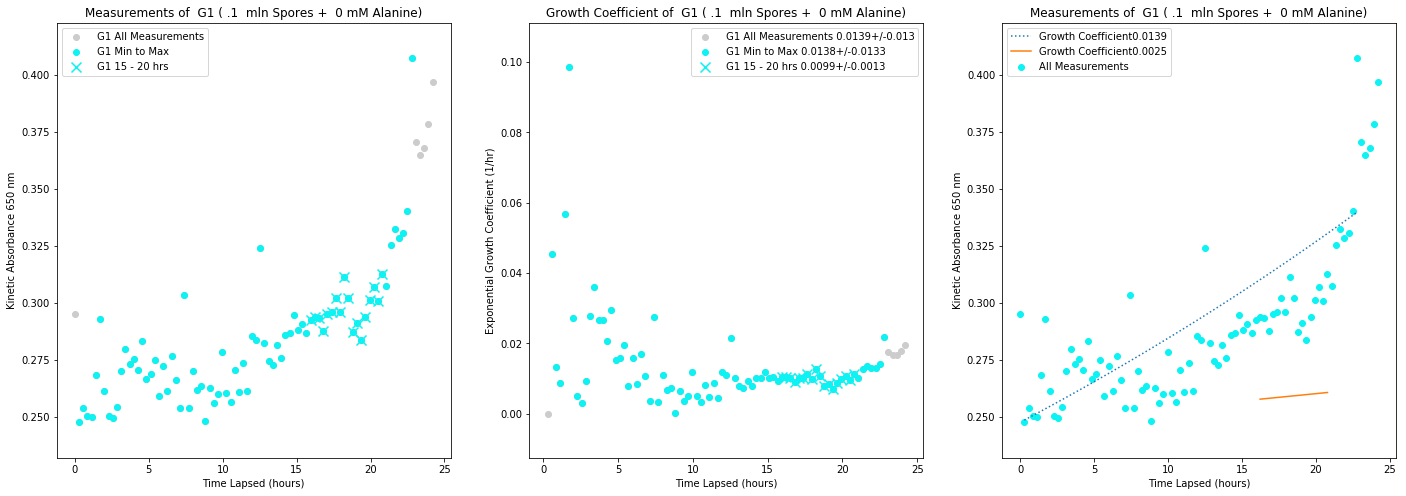

0.00603076512904


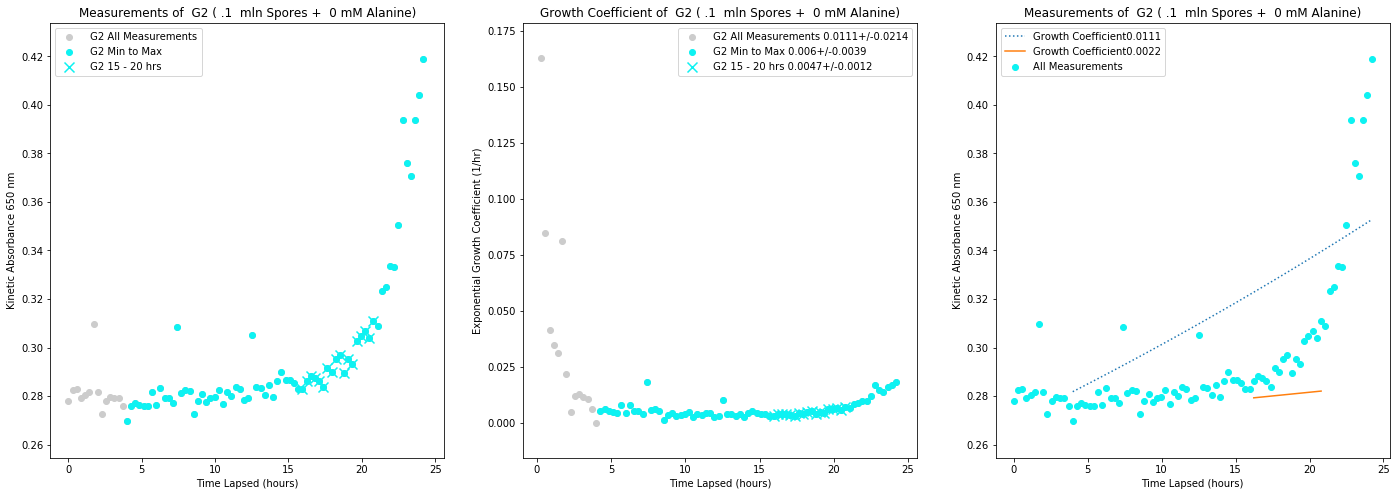

0.0189625526296


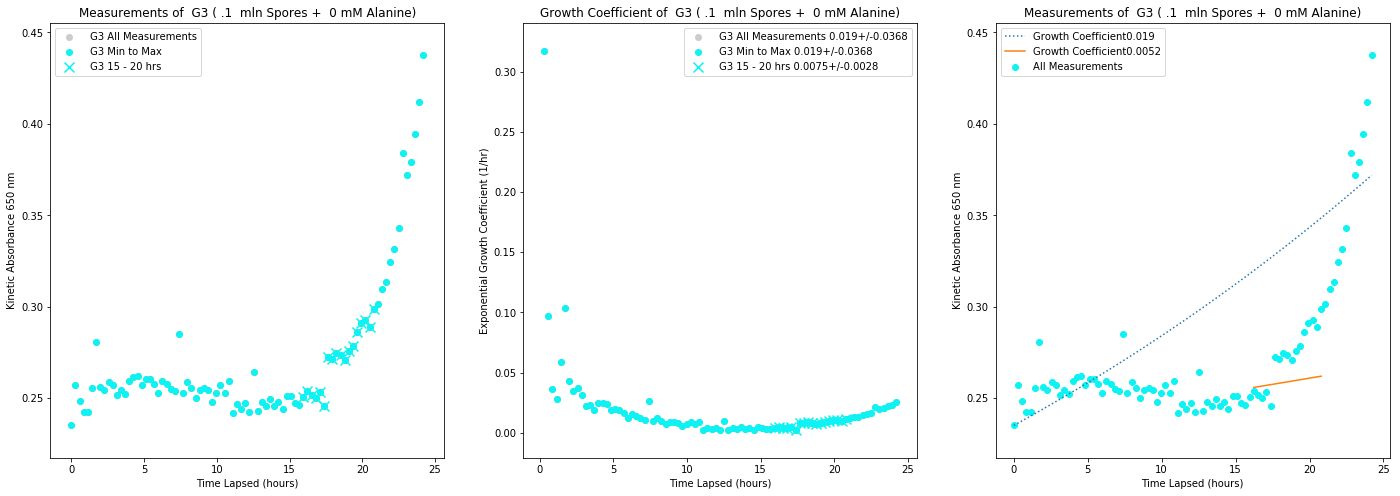

0.00682450644552


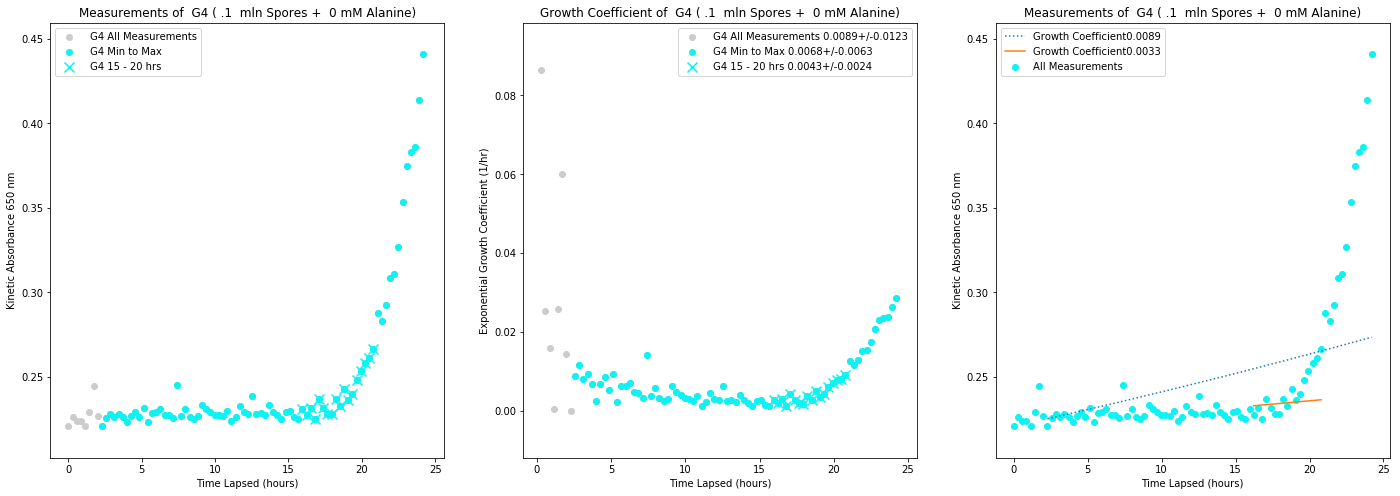

0.00808807385944


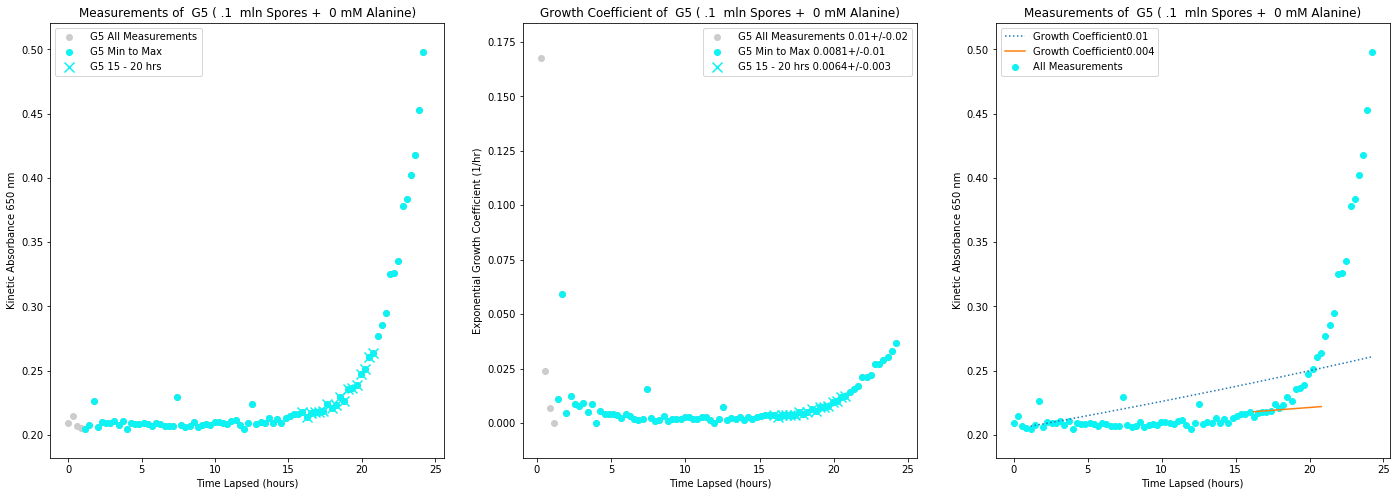

0.0188892714565


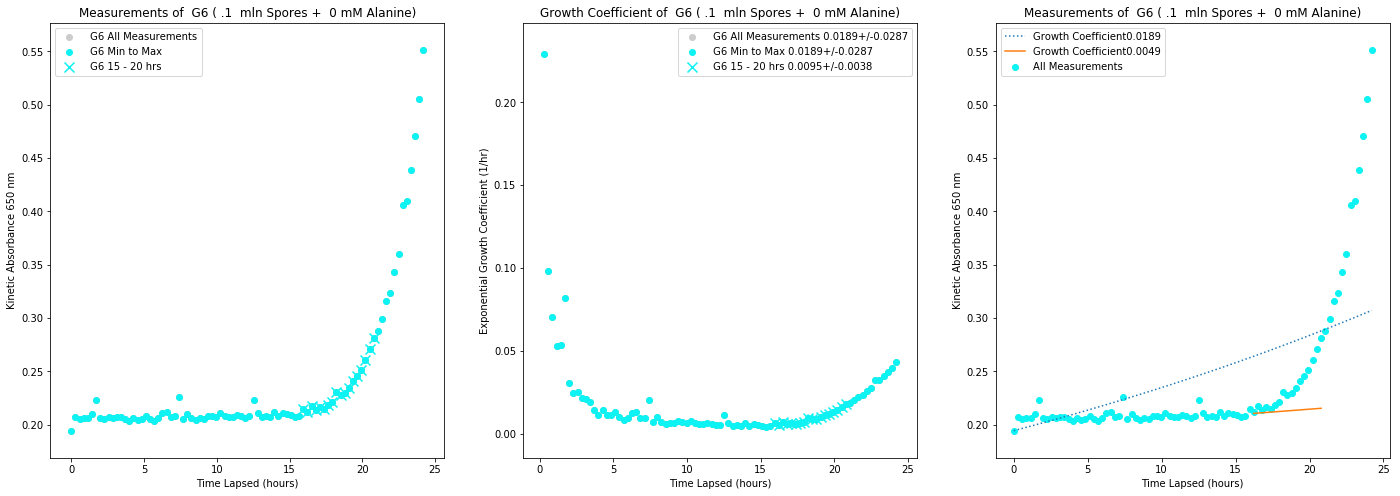

0.0255078074697


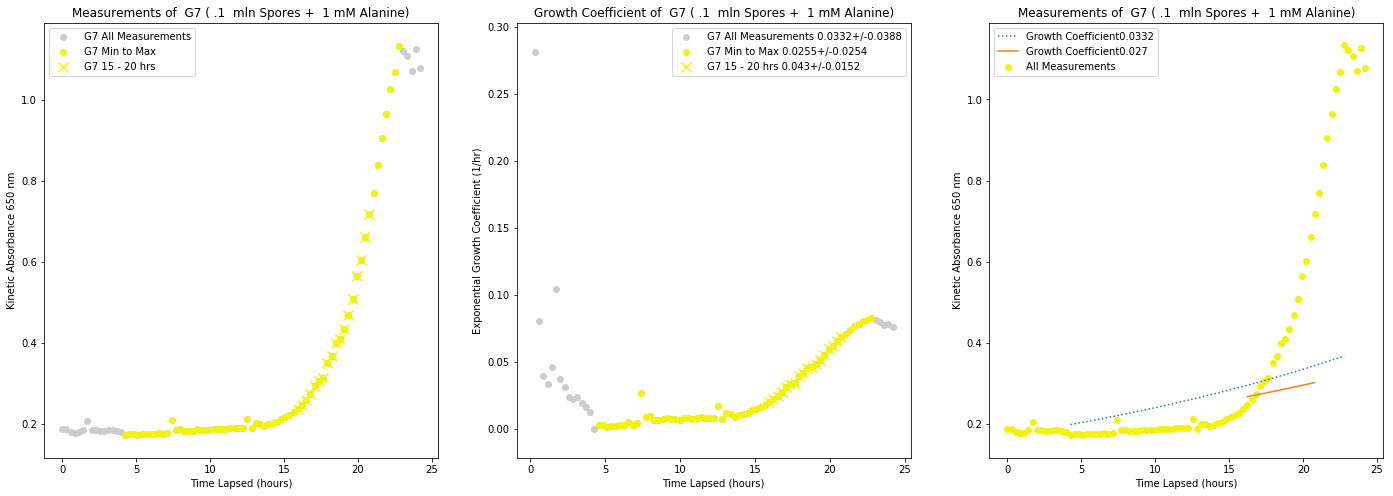

0.0552675051677


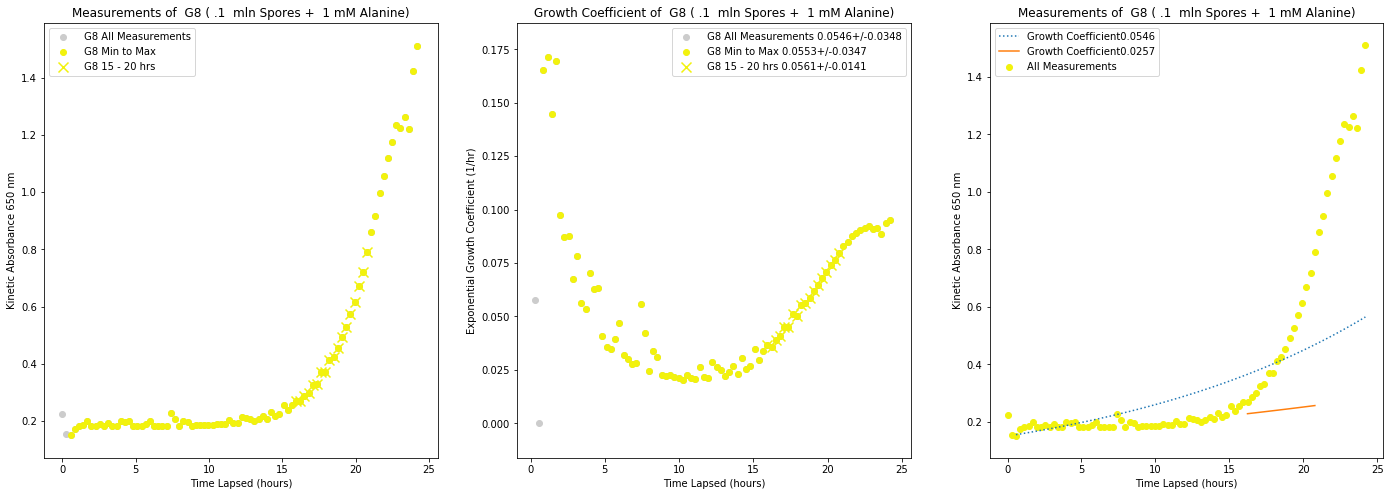

0.0373924238232


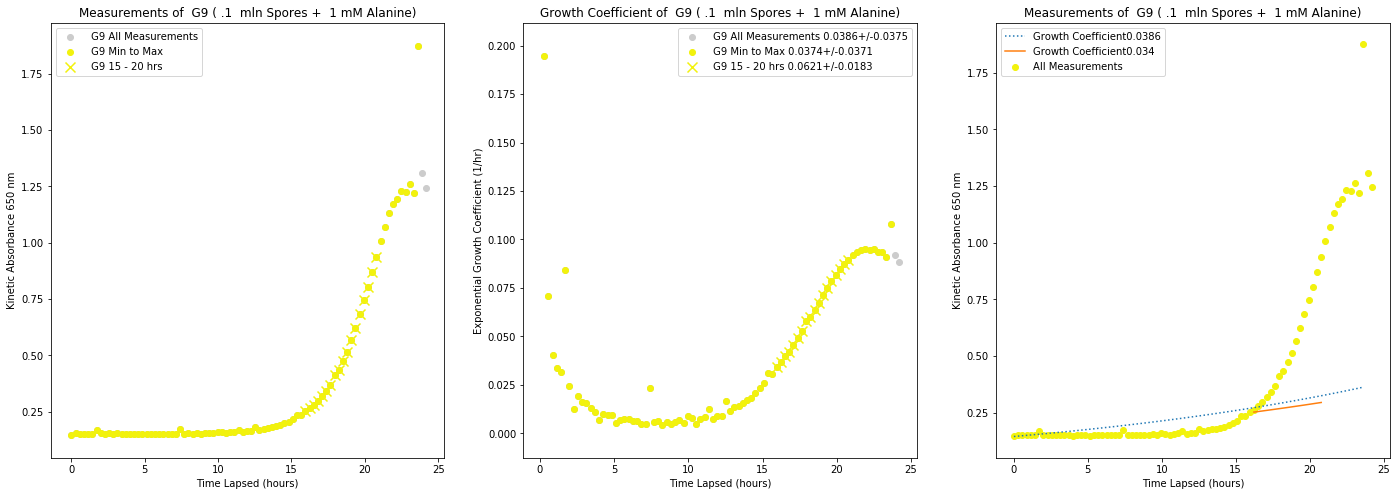

0.0393162491423


In [ ]:
if __name__ == "__main__":
    main()
    
    